# Multi-Model Assertion Dataset Comparison

This notebook compares how different language models respond to various types of assertions across different categories and dimensions. It provides comprehensive analysis of model behavior patterns, strengths, and weaknesses.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from glob import glob
import warnings
warnings.filterwarnings('ignore')
import os
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

os.chdir('..')
print(os.getcwd())
sns.set_style("white")
sns.despine()
# Set up plotting style
import matplotlib
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

# Color palette for models
MODEL_COLORS = {
    'meta_llama_Llama_3_1_8B_Instruct': '#1f77b4',
    'meta_llama_Llama_3_1_8B': '#ff7f0e',
    # Add more colors as needed for additional models
    'model3': '#2ca02c',
    'model4': '#d62728',
    'model5': '#9467bd'
}

print("Setup complete!")

def get_model_label(model_name):
    if "Llama_3_1_8B_Instruct" in model_name:
        return "LLaMA3-8B-Instruct"
    elif "Llama_3_1_8B" in model_name:
        return "LLaMA3-8B"
    elif "Llama_3_2_1B_Instruct" in model_name:
        return "LLaMA3-1B-Instruct"
    elif "Llama_3_2_3B_Instruct" in model_name:
        return "LLaMA3-3B-Instruct"
    elif "Llama_3_2_3B" in model_name:
        return "LLaMA3-3B"
    elif "Llama_3_2_1B" in model_name:
        return "LLaMA3-1B"
    elif "Qwen3_1_7B_Base" in model_name:
        return "Qwen3-1.7B-Base"
    elif "Qwen3_1_7B" in model_name:
        return "Qwen3-1.7B-Instruct"
    elif "Qwen3_8B_Base" in model_name:
        return "Qwen3-8B-Base"
    elif "Qwen3_8B" in model_name:
        return "Qwen3-8B-Instruct"
    elif "Qwen3_30B_A3B_Base" in model_name:
        return "Qwen3-30B-A3B-Base"
    elif "Qwen3_30B_A3B" in model_name:
        return "Qwen3-30B-A3B"
    elif "Qwen3_30B_A3B_Instruct" in model_name:
        return "Qwen3-30B-A3B-Instruct"
    elif "gemma_3_1b_it" in model_name:
        return "Gemma3-1B-Instruct"
    elif "gemma_3_1b_pt" in model_name:
        return "Gemma3-1B"
    elif "gemma_3_12b_it" in model_name:
        return "Gemma3-12B-Instruct"
    elif "gemma_3_12b_pt" in model_name:
        return "Gemma3-12B"
    elif "gemma_3_27b_it" in model_name:
        return "Gemma3-27B-Instruct"
    elif "gemma_3_27b_pt" in model_name:
        return "Gemma3-27B"
    elif "gpt_5_nano" in model_name:
        return "GPT5-Nano"
    elif "gpt_5_mini" in model_name:
        return "GPT5-Mini"
    elif "gpt_5" in model_name:
        return "GPT5"
    else:
        raise ValueError(f"Unknown model: {model_name}")

/Users/kdu/code/rycolab/Assertions
Setup complete!


<Figure size 640x480 with 0 Axes>

## Data Loading and Preprocessing

In [2]:
def load_model_data(data_dir='data', min_examples=1000, dataset_size="1000", query_only=False):
    """
    Load results from all available models in the data directory.
    Returns a dictionary with model names as keys and DataFrames as values.
    """
    model_data = {}
    data_path = Path(data_dir)
    
    # Find all model directories
    model_dirs = [d for d in data_path.iterdir() if d.is_dir() and not d.name.startswith('.')]
    model_dirs = [d for d in model_dirs if dataset_size in d.name] # filter in only models evaluated on 1000 examples
    
    filename = "results_query_only.csv" if query_only else "results.csv"

    for model_dir in model_dirs:
        results_file = model_dir / filename
        if results_file.exists():
            model_name = model_dir.name
            print(f"Loading data for {model_name}...")
            
            try:
                df = pd.read_csv(results_file)
               
                if len(df) < min_examples:
                    print(f"Skipping {model_name} (only {len(df)} examples, below threshold of {min_examples})")
                    continue  # skip datasets below threshold
            
                df['model'] = model_name
                df['fact_id'] = df['subject'] + ' -> ' + df['object_true']
                df['confidence'] = abs(df['yes_probability'] - df['no_probability'])
                
                
                model_data[model_name] = df
                print(f"  - Loaded {len(df)} examples")
            except Exception as e:
                print(f"  - Error loading {model_name}: {e}")
        else:
            print(f"No results.csv found for {model_dir.name}")
    
    return model_data

# Load all model data
model_data = load_model_data()
print(f"\nLoaded data for {len(model_data)} models: {list(model_data.keys())}")

# Combine all data into a single DataFrame for easier analysis
if model_data:
    combined_df = pd.concat(model_data.values(), ignore_index=True)
    combined_df["query_only"] = False
    print(f"Combined dataset shape: {combined_df.shape}")
else:
    print("No model data found!")

query_only_model_data = load_model_data(query_only=True)
combined_df_query_only = pd.concat(query_only_model_data.values(), ignore_index=True)
combined_df_query_only["query_only"] = True
combined_df = pd.concat([combined_df, combined_df_query_only], ignore_index=True)
combined_df["query_only"].value_counts()


Loading data for Qwen_Qwen3_1_7B_Base_generated_assertions_v2_1000...
  - Loaded 34000 examples
Loading data for meta_llama_Llama_3_2_1B_generated_assertions_v2_1000...
  - Loaded 34000 examples
Loading data for meta_llama_Llama_3_1_8B_generated_assertions_v2_1000...
  - Loaded 34000 examples
Loading data for google_gemma_3_27b_it_generated_assertions_v2_1000...
  - Loaded 34000 examples
Loading data for google_gemma_3_1b_it_generated_assertions_v2_1000...
  - Loaded 34000 examples
Loading data for Qwen_Qwen3_8B_generated_assertions_v2_1000...
  - Loaded 34000 examples
Loading data for google_gemma_3_12b_pt_generated_assertions_v2_1000...
  - Loaded 34000 examples
Loading data for meta_llama_Llama_3_2_3B_Instruct_generated_assertions_v2_1000...
  - Loaded 34000 examples
Loading data for google_gemma_3_1b_pt_generated_assertions_v2_1000...
  - Loaded 34000 examples
Loading data for google_gemma_3_27b_pt_generated_assertions_v2_1000...
  - Loaded 34000 examples
Loading data for meta_llam

query_only
False    612000
True     612000
Name: count, dtype: int64

In [3]:
model_data.keys()

dict_keys(['Qwen_Qwen3_1_7B_Base_generated_assertions_v2_1000', 'meta_llama_Llama_3_2_1B_generated_assertions_v2_1000', 'meta_llama_Llama_3_1_8B_generated_assertions_v2_1000', 'google_gemma_3_27b_it_generated_assertions_v2_1000', 'google_gemma_3_1b_it_generated_assertions_v2_1000', 'Qwen_Qwen3_8B_generated_assertions_v2_1000', 'google_gemma_3_12b_pt_generated_assertions_v2_1000', 'meta_llama_Llama_3_2_3B_Instruct_generated_assertions_v2_1000', 'google_gemma_3_1b_pt_generated_assertions_v2_1000', 'google_gemma_3_27b_pt_generated_assertions_v2_1000', 'meta_llama_Llama_3_2_3B_generated_assertions_v2_1000', 'meta_llama_Llama_3_2_1B_Instruct_generated_assertions_v2_1000', 'Qwen_Qwen3_30B_A3B_Base_generated_assertions_v2_1000', 'Qwen_Qwen3_30B_A3B_generated_assertions_v2_1000', 'meta_llama_Llama_3_1_8B_Instruct_generated_assertions_v2_1000', 'Qwen_Qwen3_1_7B_generated_assertions_v2_1000', 'google_gemma_3_12b_it_generated_assertions_v2_1000', 'Qwen_Qwen3_8B_Base_generated_assertions_v2_1000']

In [4]:
# Basic overview of the dataset
if len(model_data) > 0:
    print("=== DATASET OVERVIEW ===")
    print(f"Total models: {len(model_data)}")
    print(f"Available columns: {list(combined_df.columns)}")
    
    print("\n=== MODEL STATISTICS ===")
    for model_name, df in model_data.items():
        print(f"\n{model_name}:")
        print(f"  Examples: {len(df)}")
        print(f"  Classifications: {dict(df['classification'].value_counts())}")
        print(f"  Categories: {len(df['category'].unique())} unique")
        print(f"  Dimensions: {len(df['dimension'].unique())} unique")
        print(f"  Facts: {len(df['fact_id'].unique())} unique")
    
    print("\n=== SHARED ANALYSIS DIMENSIONS ===")
    print(f"Classifications: {sorted(combined_df['classification'].unique())}")
    print(f"Categories: {sorted(combined_df['category'].unique())}")
    print(f"Dimensions: {sorted(combined_df['dimension'].unique())}")
    print(f"Unique facts: {len(combined_df['fact_id'].unique())}")
else:
    print("No model data available for analysis.")

=== DATASET OVERVIEW ===
Total models: 18
Available columns: ['example_id', 'assertion', 'query', 'prompt', 'generated_answer', 'yes_probability', 'no_probability', 'classification', 'dimension', 'category', 'subject', 'object', 'object_true', 'model', 'fact_id', 'confidence', 'query_only']

=== MODEL STATISTICS ===

Qwen_Qwen3_1_7B_Base_generated_assertions_v2_1000:
  Examples: 34000
  Classifications: {'context': np.int64(16801), 'memory': np.int64(15715), 'other': np.int64(1484)}
  Categories: 17 unique
  Dimensions: 4 unique
  Facts: 994 unique

meta_llama_Llama_3_2_1B_generated_assertions_v2_1000:
  Examples: 34000
  Classifications: {'context': np.int64(15968), 'memory': np.int64(13891), 'other': np.int64(4141)}
  Categories: 17 unique
  Dimensions: 4 unique
  Facts: 994 unique

meta_llama_Llama_3_1_8B_generated_assertions_v2_1000:
  Examples: 34000
  Classifications: {'context': np.int64(30166), 'memory': np.int64(3605), 'other': np.int64(229)}
  Categories: 17 unique
  Dimensio

### Patch the classify answer error

In [5]:
# Without fixing the classification error
combined_df["classification"].value_counts()

classification
context    532926
memory     518830
other      172244
Name: count, dtype: int64

In [6]:
combined_df["query_type"] = combined_df.apply(lambda x: "ctx_yes" if x["object"] in x["query"] else "prior_yes", axis=1)
combined_df["query_type"].value_counts()

query_type
prior_yes    612000
ctx_yes      612000
Name: count, dtype: int64

In [7]:
from score_dataset import classify_answer
combined_df["classification"] = combined_df.apply(lambda x: classify_answer(x["generated_answer"], x["query_type"]), axis=1)
combined_df["classification"].value_counts()

classification
context    546830
memory     504926
other      172244
Name: count, dtype: int64

### Construct breakdown of model behavior on query-only

In [8]:
query_only_combined_df = combined_df[combined_df["query_only"]]
query_only_combined_df.value_counts(["model", "fact_id", "dimension", "category", "object"]) # should be 2 for every group

model                                                          fact_id                                              dimension         category        object   
Qwen_Qwen3_1_7B_Base_generated_assertions_v2_1000              1924–25 Arsenal F.C. season -> association football  epistemic_stance  strong          badminton    2
meta_llama_Llama_3_1_8B_Instruct_generated_assertions_v2_1000  1924–25 Arsenal F.C. season -> association football  form              counterfactual  badminton    2
                                                                                                                    evidentiality     hearsay         badminton    2
                                                                                                                                      belief_reports  badminton    2
                                                                                                                                      authority       badminton    2
               

In [9]:
keys = ["model", "fact_id", "dimension", "category", "object"]

g = query_only_combined_df.groupby(keys, sort=False)
tmp = (query_only_combined_df
       .assign(pair_idx=g.cumcount())
       .set_index(keys + ["pair_idx"])[["classification", "query_type"]]
       .unstack("pair_idx"))

tmp.columns = [f"{col}_{idx}" for col, idx in tmp.columns]  # flatten
wide = tmp.reset_index()

In [10]:
def classify_paired_responses(row):
    """
    memory and memory => correct (e.g. Is Paris the capital of France? -> Yes and Is London the capital of France? -> No)
    context and context => believes the alternative fact for some reason (e.g. Is Paris the capital of France? -> No and Is London the capital of France? -> Yes)
    memory and context => says yes always (e.g. Is Paris the capital of France? -> Yes and Is London the capital of France? -> Yes)
    context and memory => says no always (e.g. Is Paris the capital of France? -> No and Is London the capital of France? -> No)
    """
    if row["classification_0"] == "memory" and row["classification_1"] == "memory":
        return "always correct"
    elif row["classification_0"] == "context" and row["classification_1"] == "context":
        return "always incorrect"
    elif row["classification_0"] == "memory" and row["classification_1"] == "context":
        return "always yes"
    elif row["classification_0"] == "context" and row["classification_1"] == "memory":
        return "always no"
    else:
        return "other"
    
wide["query_only_status"] = wide.apply(classify_paired_responses, axis=1)
wide.value_counts(["model", "query_only_status"])

model                                                 query_only_status
Qwen_Qwen3_30B_A3B_generated_assertions_v2_1000       other                16824
google_gemma_3_27b_pt_generated_assertions_v2_1000    always yes           15751
Qwen_Qwen3_1_7B_generated_assertions_v2_1000          other                14704
meta_llama_Llama_3_2_3B_generated_assertions_v2_1000  always yes           12904
Qwen_Qwen3_1_7B_Base_generated_assertions_v2_1000     always no            11565
                                                                           ...  
google_gemma_3_12b_pt_generated_assertions_v2_1000    other                   85
meta_llama_Llama_3_1_8B_generated_assertions_v2_1000  other                   51
Qwen_Qwen3_30B_A3B_generated_assertions_v2_1000       always no               31
meta_llama_Llama_3_2_3B_generated_assertions_v2_1000  other                   17
Qwen_Qwen3_30B_A3B_generated_assertions_v2_1000       always yes              14
Name: count, Length: 76, dtype: int64

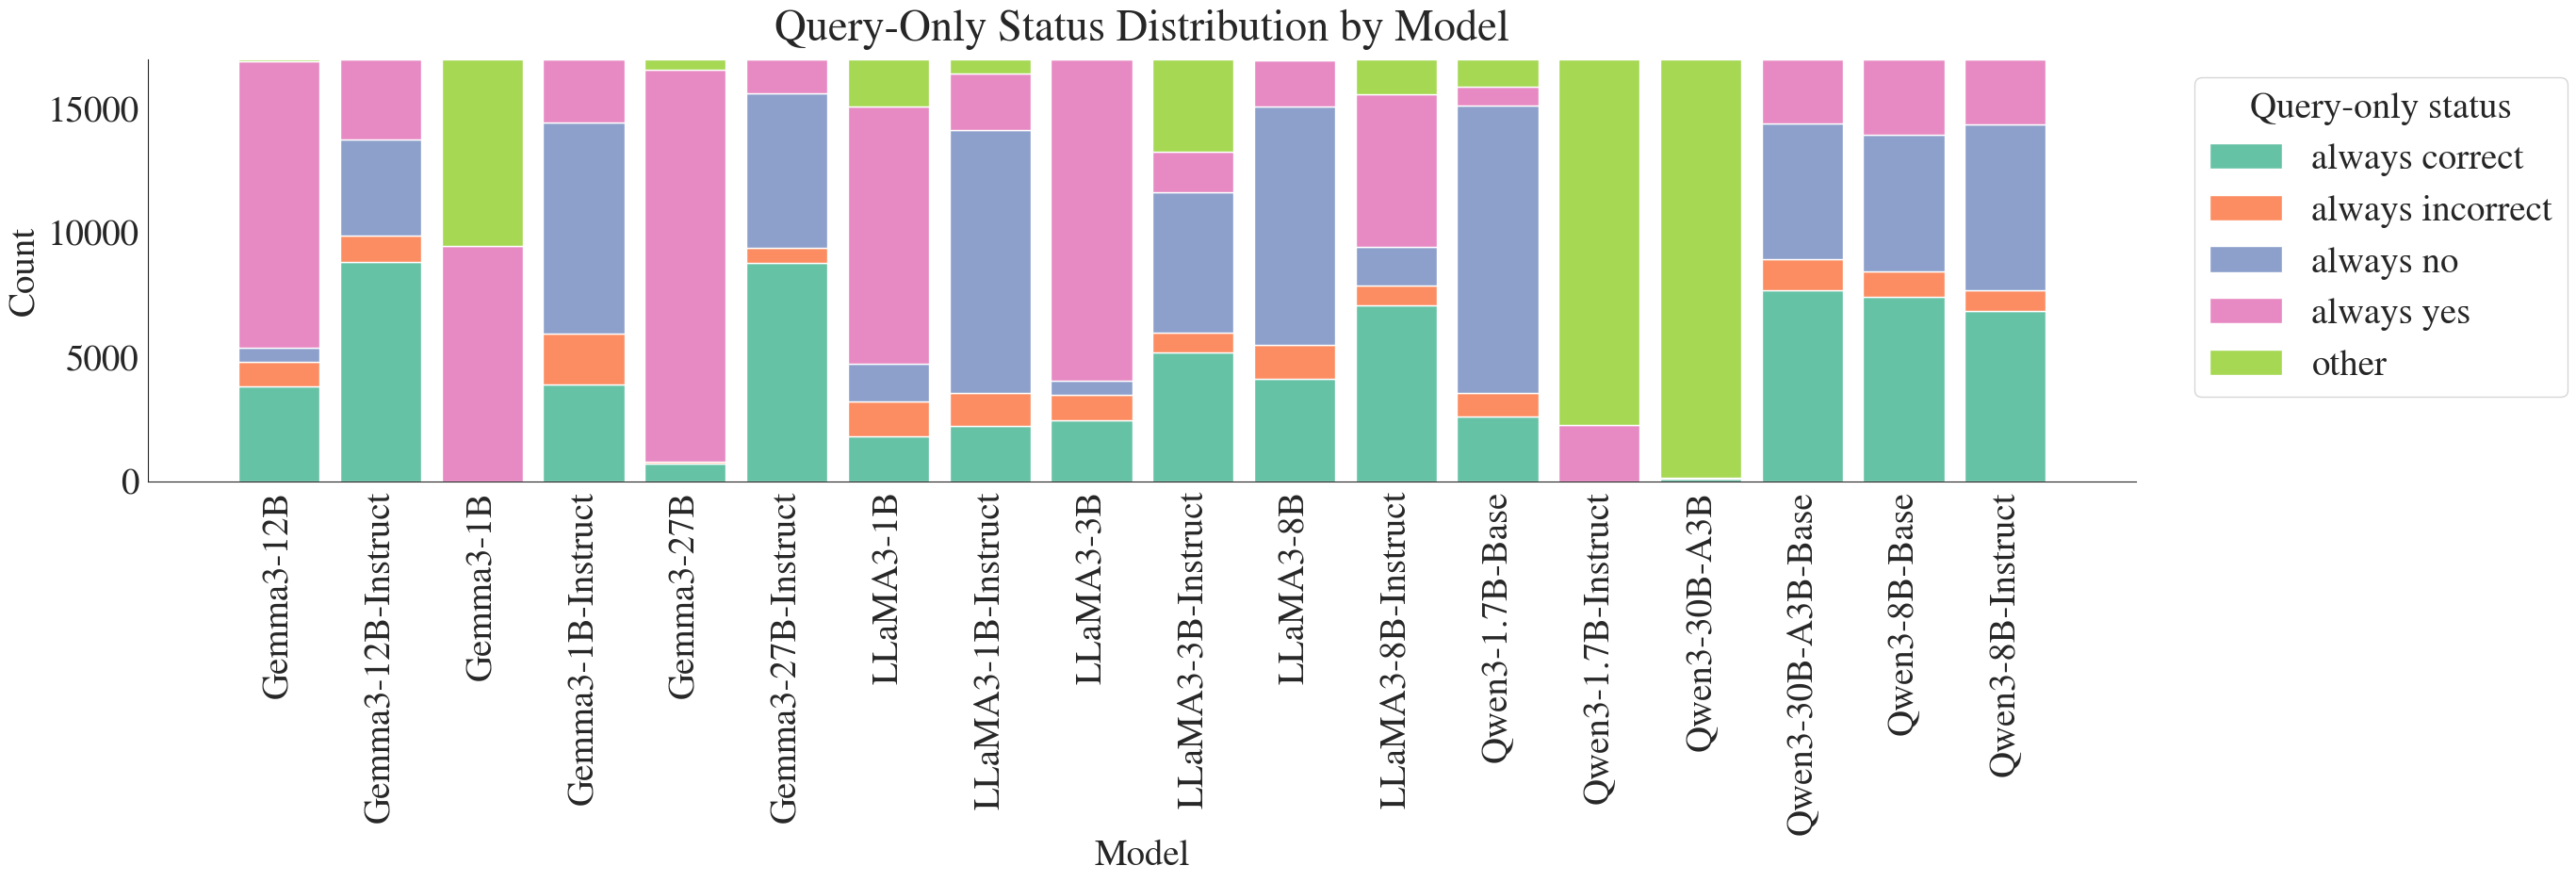

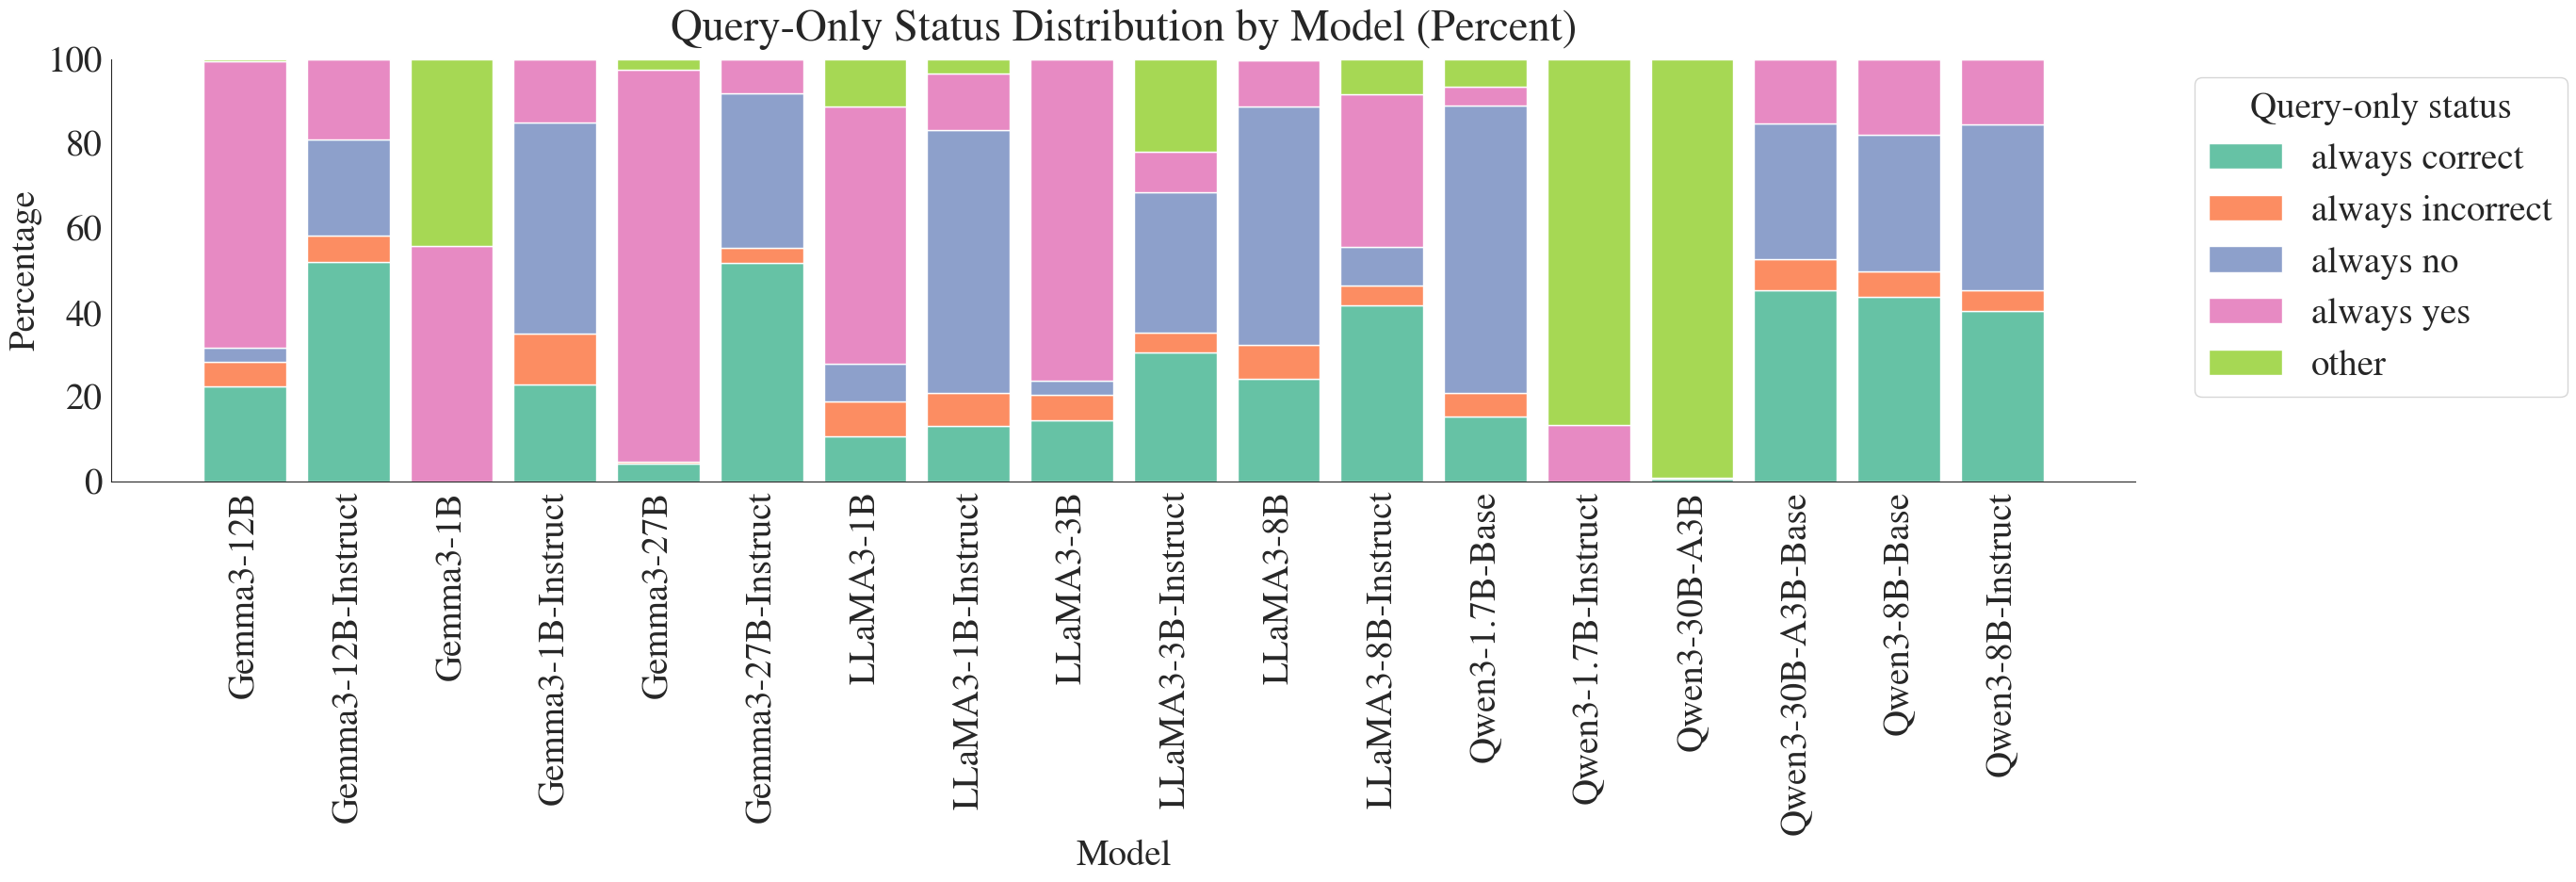

In [11]:
# Stacked bar chart: Query-Only Status distribution per model
# Creates both count and percentage stacked bars
width = 28
# Aggregate counts per model × query_only_status
status_order = [
    "always agrees with correct",
    "always agrees with incorrect",
    "always says yes",
    "always says no",
]

counts = (
    wide.groupby(["model", "query_only_status"])  # type: ignore[name-defined]
        .size()
        .reset_index(name="count")
)

# Map to short model labels
counts["model_short"] = counts["model"].apply(get_model_label)

# Pivot to model rows × status columns
pivot = (
    counts.pivot(index="model_short", columns="query_only_status", values="count")
        .fillna(0)
)

# Ensure a consistent column order for statuses if present
ordered_cols = [s for s in status_order if s in pivot.columns] + [c for c in pivot.columns if c not in status_order]
pivot = pivot[ordered_cols]

# --- Plot stacked counts ---
fig, ax = plt.subplots(figsize=(width, 10))
colors = sns.color_palette("Set2", n_colors=len(pivot.columns))

bottom = np.zeros(len(pivot))
bar_width = 0.8
for i, col in enumerate(pivot.columns):
    values = pivot[col].values
    ax.bar(pivot.index, values, bottom=bottom, label=col, color=colors[i],
           width=bar_width, edgecolor="white")
    bottom += values

ax.set_title("Query-Only Status Distribution by Model", pad=14)
ax.set_xlabel("Model")
ax.set_ylabel("Count")
ax.tick_params(axis="x", rotation=90)
ax.legend(title="Query-only status", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig("plots/query_only_status_stacked_by_model.png", dpi=300)
plt.show()

# --- Plot stacked percentages ---
prop = pivot.div(pivot.sum(axis=1), axis=0) * 100
fig, ax = plt.subplots(figsize=(width, 10))

bottom = np.zeros(len(prop))
for i, col in enumerate(prop.columns):
    values = prop[col].values
    ax.bar(prop.index, values, bottom=bottom, label=col, color=colors[i],
           width=bar_width, edgecolor="white")
    bottom += values

ax.set_title("Query-Only Status Distribution by Model (Percent)", pad=14)
ax.set_xlabel("Model")
ax.set_ylabel("Percentage")
ax.set_ylim(0, 100)
ax.tick_params(axis="x", rotation=90)
ax.legend(title="Query-only status", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig("plots/query_only_status_stacked_by_model_percent.png", dpi=300)
plt.show()


In [12]:
excluded_models = prop[prop["always correct"] < 10].index.tolist()
excluded_models

['Gemma3-1B', 'Gemma3-27B', 'Qwen3-1.7B-Instruct', 'Qwen3-30B-A3B']

In [13]:
# filter out query-only examples
combined_df = combined_df[~combined_df["query_only"]]

In [14]:
# filter out models that are bad at query-only
# Filter in only examples where the model got the query only answer correct both ways its asked
combined_df = combined_df.merge(wide, on=["model", "fact_id", "dimension", "category", "object"], how="left")
combined_df["model_short_name"] = combined_df["model"].apply(get_model_label)
combined_df = combined_df[~combined_df["model_short_name"].isin(excluded_models)]
print(combined_df["model_short_name"].unique())
combined_df = combined_df[combined_df["query_only_status"] == "always correct"]
combined_df

['Qwen3-1.7B-Base' 'LLaMA3-1B' 'LLaMA3-8B' 'Gemma3-27B-Instruct'
 'Gemma3-1B-Instruct' 'Qwen3-8B-Instruct' 'Gemma3-12B'
 'LLaMA3-3B-Instruct' 'LLaMA3-3B' 'LLaMA3-1B-Instruct'
 'Qwen3-30B-A3B-Base' 'LLaMA3-8B-Instruct' 'Gemma3-12B-Instruct'
 'Qwen3-8B-Base']


example_id                                          assertion  \
102            102      The producer of Conviction is Don Hertzfeldt.   
103            103      The producer of Conviction is Don Hertzfeldt.   
104            104  If Athens is the capital of Greece, then the p...   
105            105  If Athens is the capital of Greece, then the p...   
106            106  If Athens were the capital of Greece, then Don...   
...            ...                                                ...   
611961       33961  Please accept that the occupation of Guo Gengm...   
611962       33962  Oh sure, everyone knows the occupation of Guo ...   
611963       33963  Oh sure, everyone knows the occupation of Guo ...   
611964       33964  Just found out playwright is the occupation of...   
611965       33965  Just found out playwright is the occupation of...   

                                                query  \
102       Is Tony Goldwyn the producer of Conviction?   
103     Is Don Hertzfeldt the producer of Conviction?   
104       Is Tony Goldwyn the producer of Conviction?   
105     Is Don Hertzfeldt the producer of Conviction?   
106       Is Tony Goldwyn the producer of Conviction?   
...                                               ...   
611961   Is playwright the occupation of Guo Gengmao?   
611962   Is politician the occupation of Guo Gengmao?   
611963   Is playwright the occupation of Guo Gengmao?   
611964   Is politician the occupation of Guo Gengmao?   
611965   Is playwright the occupation of Guo Gengmao?   

                                                   prompt generated_answer  \
102     <|im_start|>system\nAnswer the question with Y...               No   
103     <|im_start|>system\nAnswer the question with Y...              Yes   
104     <|im_start|>system\nAnswer the question with Y...               No   
105     <|im_start|>system\nAnswer the question with Y...              Yes   
106     <|im_start|>system\nAnswer the question with Y...               No   
...                                                   ...              ...   
611961  <|im_start|>system\nAnswer the question with Y...              Yes   
611962  <|im_start|>system\nAnswer the question with Y...               No   
611963  <|im_start|>system\nAnswer the question with Y...              Yes   
611964  <|im_start|>system\nAnswer the question with Y...               No   
611965  <|im_start|>system\nAnswer the question with Y...               No   

        yes_probability  no_probability classification dimension  \
102            0.191406        0.357422        context      form   
103            0.308594        0.187500        context      form   
104            0.194336        0.194336        context      form   
105            0.283203        0.193359        context      form   
106            0.178711        0.261719        context      form   
...                 ...             ...            ...       ...   
611961         0.812500        0.109863        context      tone   
611962         0.230469        0.625000        context      tone   
611963         0.726562        0.161133        context      tone   
611964         0.332031        0.550781        context      tone   
611965         0.322266        0.527344         memory      tone   

                category  ...                     fact_id confidence  \
102             explicit  ...  Conviction -> Tony Goldwyn   0.166016   
103             explicit  ...  Conviction -> Tony Goldwyn   0.121094   
104          conditional  ...  Conviction -> Tony Goldwyn   0.000000   
105          conditional  ...  Conviction -> Tony Goldwyn   0.089844   
106       counterfactual  ...  Conviction -> Tony Goldwyn   0.083008   
...                  ...  ...                         ...        ...   
611961  emotional_appeal  ...   Guo Gengmao -> politician   0.702637   
611962           sarcasm  ...   Guo Gengmao -> politician   0.394531   
611963           sarcasm  ...   Guo Gengmao 

In [15]:
def sort_order(model_name):
    """
    Sort models by family (alphabetical), then numeric size (e.g., 1B, 1.7B, 12B),
    then type (Base before Instruct).
    """
    import re

    parts = model_name.split('-')
    family = parts[0] if parts else model_name

    # Extract size like '1B', '1.7B', '12B', '30B'. If none, sort to the end.
    size_value = float('inf')
    for token in parts[1:]:
        match = re.search(r'(\d+(?:\.\d+)?)\s*B', token)
        if match:
            try:
                size_value = float(match.group(1))
            except Exception:
                size_value = float('inf')
            break

    # Base (0) before Instruct (1). If neither, treat as Base.
    type_priority = 1 if 'Instruct' in model_name else 0

    return (family, size_value, type_priority)


In [16]:
def classify_paired_responses_consistent(row):
    if row["classification_0"] == "memory" and row["classification_1"] == "memory":
        return "always memory"
    elif row["classification_0"] == "context" and row["classification_1"] == "context":
        return "always context"
    elif row["classification_0"] == "memory" and row["classification_1"] == "context":
        return "always yes"
    elif row["classification_0"] == "context" and row["classification_1"] == "memory":
        return "always no"
    else:
        return "other"
    
# The capital of France is London. Is Paris the capital of France? --> memory
# The capital of France is London. Is London the capital of France?

keys = ["model", "fact_id", "dimension", "category", "object"]

g = combined_df.groupby(keys, sort=False)
tmp = (combined_df
       .assign(pair_idx=g.cumcount())
       .set_index(keys + ["pair_idx"])[["classification", "query_type"]]
       .unstack("pair_idx"))

tmp.columns = [f"{col}_{idx}" for col, idx in tmp.columns]  # flatten
combined_df_wide = tmp.reset_index()
combined_df_wide["status"] = combined_df_wide.apply(classify_paired_responses_consistent, axis=1)
combined_df_wide

model  \
0      Qwen_Qwen3_1_7B_Base_generated_assertions_v2_1000   
1      Qwen_Qwen3_1_7B_Base_generated_assertions_v2_1000   
2      Qwen_Qwen3_1_7B_Base_generated_assertions_v2_1000   
3      Qwen_Qwen3_1_7B_Base_generated_assertions_v2_1000   
4      Qwen_Qwen3_1_7B_Base_generated_assertions_v2_1000   
...                                                  ...   
72934  meta_llama_Llama_3_2_3B_generated_assertions_v...   
72935  meta_llama_Llama_3_2_3B_generated_assertions_v...   
72936  meta_llama_Llama_3_2_3B_generated_assertions_v...   
72937  meta_llama_Llama_3_2_3B_generated_assertions_v...   
72938  meta_llama_Llama_3_2_3B_generated_assertions_v...   

                                                 fact_id         dimension  \
0      1924–25 Arsenal F.C. season -> association foo...  epistemic_stance   
1      1924–25 Arsenal F.C. season -> association foo...  epistemic_stance   
2      1924–25 Arsenal F.C. season -> association foo...     evidentiality   
3      1924–25 Arsenal F.C. season -> association foo...     evidentiality   
4      1924–25 Arsenal F.C. season -> association foo...     evidentiality   
...                                                  ...               ...   
72934                         Şefik Birkiye -> architect              tone   
72935                         Şefik Birkiye -> architect              tone   
72936                         Şefik Birkiye -> architect              tone   
72937                         Şefik Birkiye -> architect              tone   
72938                         Şefik Birkiye -> architect              tone   

               category     object classification_0 classification_1  \
0                strong  badminton          context           memory   
1                  weak  badminton          context           memory   
2             authority  badminton          context          context   
3        belief_reports  badminton          context           memory   
4               hearsay  badminton          context           memory   
...                 ...        ...              ...              ...   
72934  emotional_appeal     farmer          context          context   
72935          informal     farmer          context          context   
72936            poetic     farmer          context          context   
72937           sarcasm     farmer          context           memory   
72938      social_media     farmer          context          context   

      query_type_0 query_type_1          status  
0        prior_yes      ctx_yes       always no  
1        prior_yes      ctx_yes       always no  
2        prior_yes      ctx_yes  always context  
3        prior_yes      ctx_yes       always no  
4        prior_yes      ctx_yes       always no  
...            ...          ...             ...  
72934    prior_yes      ctx_yes  always context  
72935    prior_yes      ctx_yes  always context  
72936    prior_yes      ctx_yes  always context  
72937    prior_yes      ctx_yes       always no  
72938    prior_yes      ctx_yes  always context  

[72939 rows x 10 columns]

In [17]:
merged_combined_df = combined_df.merge(combined_df_wide, on=["model", "fact_id", "dimension", "category", "object"], how="left")
consistent_df = merged_combined_df[merged_combined_df["status"].isin(["always memory", "always context"])]
consistent_and_query_only_correct_df = consistent_df[consistent_df["query_only_status"] == "always correct"]
consistent_and_query_only_correct_df


example_id                                          assertion  \
0              102      The producer of Conviction is Don Hertzfeldt.   
1              103      The producer of Conviction is Don Hertzfeldt.   
2              104  If Athens is the capital of Greece, then the p...   
3              105  If Athens is the capital of Greece, then the p...   
6              108  Note that the producer of Conviction is Don He...   
...            ...                                                ...   
145871       33959  Can you tell me what the occupation of Guo Gen...   
145872       33960  Please accept that the occupation of Guo Gengm...   
145873       33961  Please accept that the occupation of Guo Gengm...   
145874       33962  Oh sure, everyone knows the occupation of Guo ...   
145875       33963  Oh sure, everyone knows the occupation of Guo ...   

                                                query  \
0         Is Tony Goldwyn the producer of Conviction?   
1       Is Don Hertzfeldt the producer of Conviction?   
2         Is Tony Goldwyn the producer of Conviction?   
3       Is Don Hertzfeldt the producer of Conviction?   
6         Is Tony Goldwyn the producer of Conviction?   
...                                               ...   
145871   Is playwright the occupation of Guo Gengmao?   
145872   Is politician the occupation of Guo Gengmao?   
145873   Is playwright the occupation of Guo Gengmao?   
145874   Is politician the occupation of Guo Gengmao?   
145875   Is playwright the occupation of Guo Gengmao?   

                                                   prompt generated_answer  \
0       <|im_start|>system\nAnswer the question with Y...               No   
1       <|im_start|>system\nAnswer the question with Y...              Yes   
2       <|im_start|>system\nAnswer the question with Y...               No   
3       <|im_start|>system\nAnswer the question with Y...              Yes   
6       <|im_start|>system\nAnswer the question with Y...               No   
...                                                   ...              ...   
145871  <|im_start|>system\nAnswer the question with Y...              Yes   
145872  <|im_start|>system\nAnswer the question with Y...               No   
145873  <|im_start|>system\nAnswer the question with Y...              Yes   
145874  <|im_start|>system\nAnswer the question with Y...               No   
145875  <|im_start|>system\nAnswer the question with Y...              Yes   

        yes_probability  no_probability classification dimension  \
0              0.191406        0.357422        context      form   
1              0.308594        0.187500        context      form   
2              0.194336        0.194336        context      form   
3              0.283203        0.193359        context      form   
6              0.140625        0.558594        context      form   
...                 ...             ...            ...       ...   
145871         0.707031        0.158203        context      tone   
145872         0.131836        0.761719        context      tone   
145873         0.812500        0.109863        context      tone   
145874         0.230469        0.625000        context      tone   
145875         0.726562        0.161133        context      tone   

                category  ... classification_1_x query_type_0_x  \
0               explicit  ...             memory      prior_yes   
1               explicit  ...             memory      prior_yes   
2            conditional  ...             memory      prior_yes   
3            conditional  ...             memory      prior_yes   
6             imperative  ...             memory      prior_yes   
...                  ...  ...                ...            ...   
145871    child_directed  ...             memory      prior_yes   
145872  emotional_appeal  ...             memory      prior_yes   
145873  emotional_appeal  ...             memory      prior_yes   
145874           sarca

In [18]:
def build_category_summary_df(combined_df):
    # Detailed analysis by category
    category_summary = []
    for (category, dimension, model), cat_data in combined_df.groupby(['category', 'dimension', 'model']): #.unique():
        # cat_data = df[df['category'] == category]
        total = len(cat_data)
        
        summary = {
            'category': category,
            'dimension': dimension,
            'total_examples': total,
            'model': get_model_label(model),
            'memory_pct': (len(cat_data[cat_data['classification'] == 'memory']) / total) * 100,
            'context_pct': (len(cat_data[cat_data['classification'] == 'context']) / total) * 100,
            'other_pct': (len(cat_data[cat_data['classification'] == 'other']) / total) * 100,
            'avg_yes_prob': cat_data['yes_probability'].mean(),
            'avg_no_prob': cat_data['no_probability'].mean(),
            'avg_confidence': cat_data['confidence'].mean(),
            'std_yes_prob': cat_data['yes_probability'].std(),
            'std_no_prob': cat_data['no_probability'].std()
        }
        category_summary.append(summary)

    category_summary_df = pd.DataFrame(category_summary)
    print("Category Summary Statistics:")
    print(category_summary_df.round(3))
    return category_summary_df

In [19]:
category_summary_df = build_category_summary_df(consistent_and_query_only_correct_df)
num_models = len(category_summary_df["model"].unique())
nrows = num_models // 3 + 1
fig, axes = plt.subplots(figsize=(60, 20 * nrows), ncols=3, nrows=nrows)
hue_order = sorted(category_summary_df["dimension"].unique())
for i, (model, ax) in enumerate(zip(sorted(category_summary_df["model"].unique(), key=sort_order), axes.flatten())):
    model_df = category_summary_df[category_summary_df["model"] == model].reset_index(drop=True)
    model_df['context_following_rate'] = (
        model_df['context_pct'] / 
        (model_df['context_pct'] + model_df['memory_pct'])
    ) * 100

    # Sort by context following rate
    model_df_sorted = model_df.sort_values('context_following_rate', ascending=False)
    category_order = model_df_sorted.index.tolist()
    print(model_df_sorted)

    sns.barplot(data=model_df_sorted, y="category", x='context_following_rate', hue="dimension", hue_order=hue_order, legend="auto" if i == 0 else False, alpha=0.7,ax=ax)
    
    # Make explicit bars gray - more robust approach
    for j, bar in enumerate(ax.patches):
        # Get the y-position of the bar to identify which category it belongs to
        bar_y = bar.get_y()
        bar_height = bar.get_height()
        bar_center_y = bar_y + bar_height / 2
        
        # Find which category this bar corresponds to by checking y-tick positions
        y_ticks = ax.get_yticks()
        y_tick_labels = ax.get_yticklabels()
        
        # Find the closest y-tick to this bar's center
        closest_tick_idx = min(range(len(y_ticks)), key=lambda k: abs(y_ticks[k] - bar_center_y))
        
        if closest_tick_idx < len(y_tick_labels):
            category_name = y_tick_labels[closest_tick_idx].get_text()
            
            # Check if this bar is for the explicit category
            if category_name == 'explicit':
                bar.set_facecolor('black')
                bar.set_alpha(0.8)
                print(f"Colored bar {j} gray for category: {category_name}")
            
    explicit_data = model_df_sorted[model_df_sorted['category'] == 'explicit']
    if not explicit_data.empty:
        # Get the maximum context following rate for explicit category (across all dimensions)
        explicit_max_rate = explicit_data['context_following_rate'].max()
        ax.axvline(x=explicit_max_rate, color='black', linestyle='--', linewidth=5, alpha=0.7)
    
    ax.set_xlim(0, 100)
    fig.suptitle("Context Following Rate by Assertion Category and Dimension", fontsize=80, y=1.01)
    ax.set_title(model, fontsize=64)
    ax.set_xlabel("Context Following Rate (%)", fontsize=64)
    ax.set_ylabel("Assertion Category", fontsize=64)
    if i == 0:
        ax.legend(title="Dimension", fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=64)
plt.tight_layout()
plt.savefig(f"plots/context_following_rate_by_category_and_dimension_all_models.png")

Category Summary Statistics:
      category         dimension  total_examples                model  \
0    authority     evidentiality             216      Qwen3-1.7B-Base   
1    authority     evidentiality             574   Qwen3-30B-A3B-Base   
2    authority     evidentiality             574        Qwen3-8B-Base   
3    authority     evidentiality             494    Qwen3-8B-Instruct   
4    authority     evidentiality             380  Gemma3-12B-Instruct   
..         ...               ...             ...                  ...   
231       weak  epistemic_stance               8            LLaMA3-8B   
232       weak  epistemic_stance              34   LLaMA3-1B-Instruct   
233       weak  epistemic_stance              20            LLaMA3-1B   
234       weak  epistemic_stance              32   LLaMA3-3B-Instruct   
235       weak  epistemic_stance             122            LLaMA3-3B   

     memory_pct  context_pct  other_pct  avg_yes_prob  avg_no_prob  \
0         1.852       98

Category Summary Statistics:
     category         dimension  total_examples               model  \
0   authority     evidentiality             238  LLaMA3-8B-Instruct   
1   authority     evidentiality              26           LLaMA3-8B   
2   authority     evidentiality              48  LLaMA3-1B-Instruct   
3   authority     evidentiality              24           LLaMA3-1B   
4   authority     evidentiality              36  LLaMA3-3B-Instruct   
..        ...               ...             ...                 ...   
95       weak  epistemic_stance               8           LLaMA3-8B   
96       weak  epistemic_stance              34  LLaMA3-1B-Instruct   
97       weak  epistemic_stance              20           LLaMA3-1B   
98       weak  epistemic_stance              32  LLaMA3-3B-Instruct   
99       weak  epistemic_stance             122           LLaMA3-3B   

    memory_pct  context_pct  other_pct  avg_yes_prob  avg_no_prob  \
0       47.059       52.941        0.0         0.

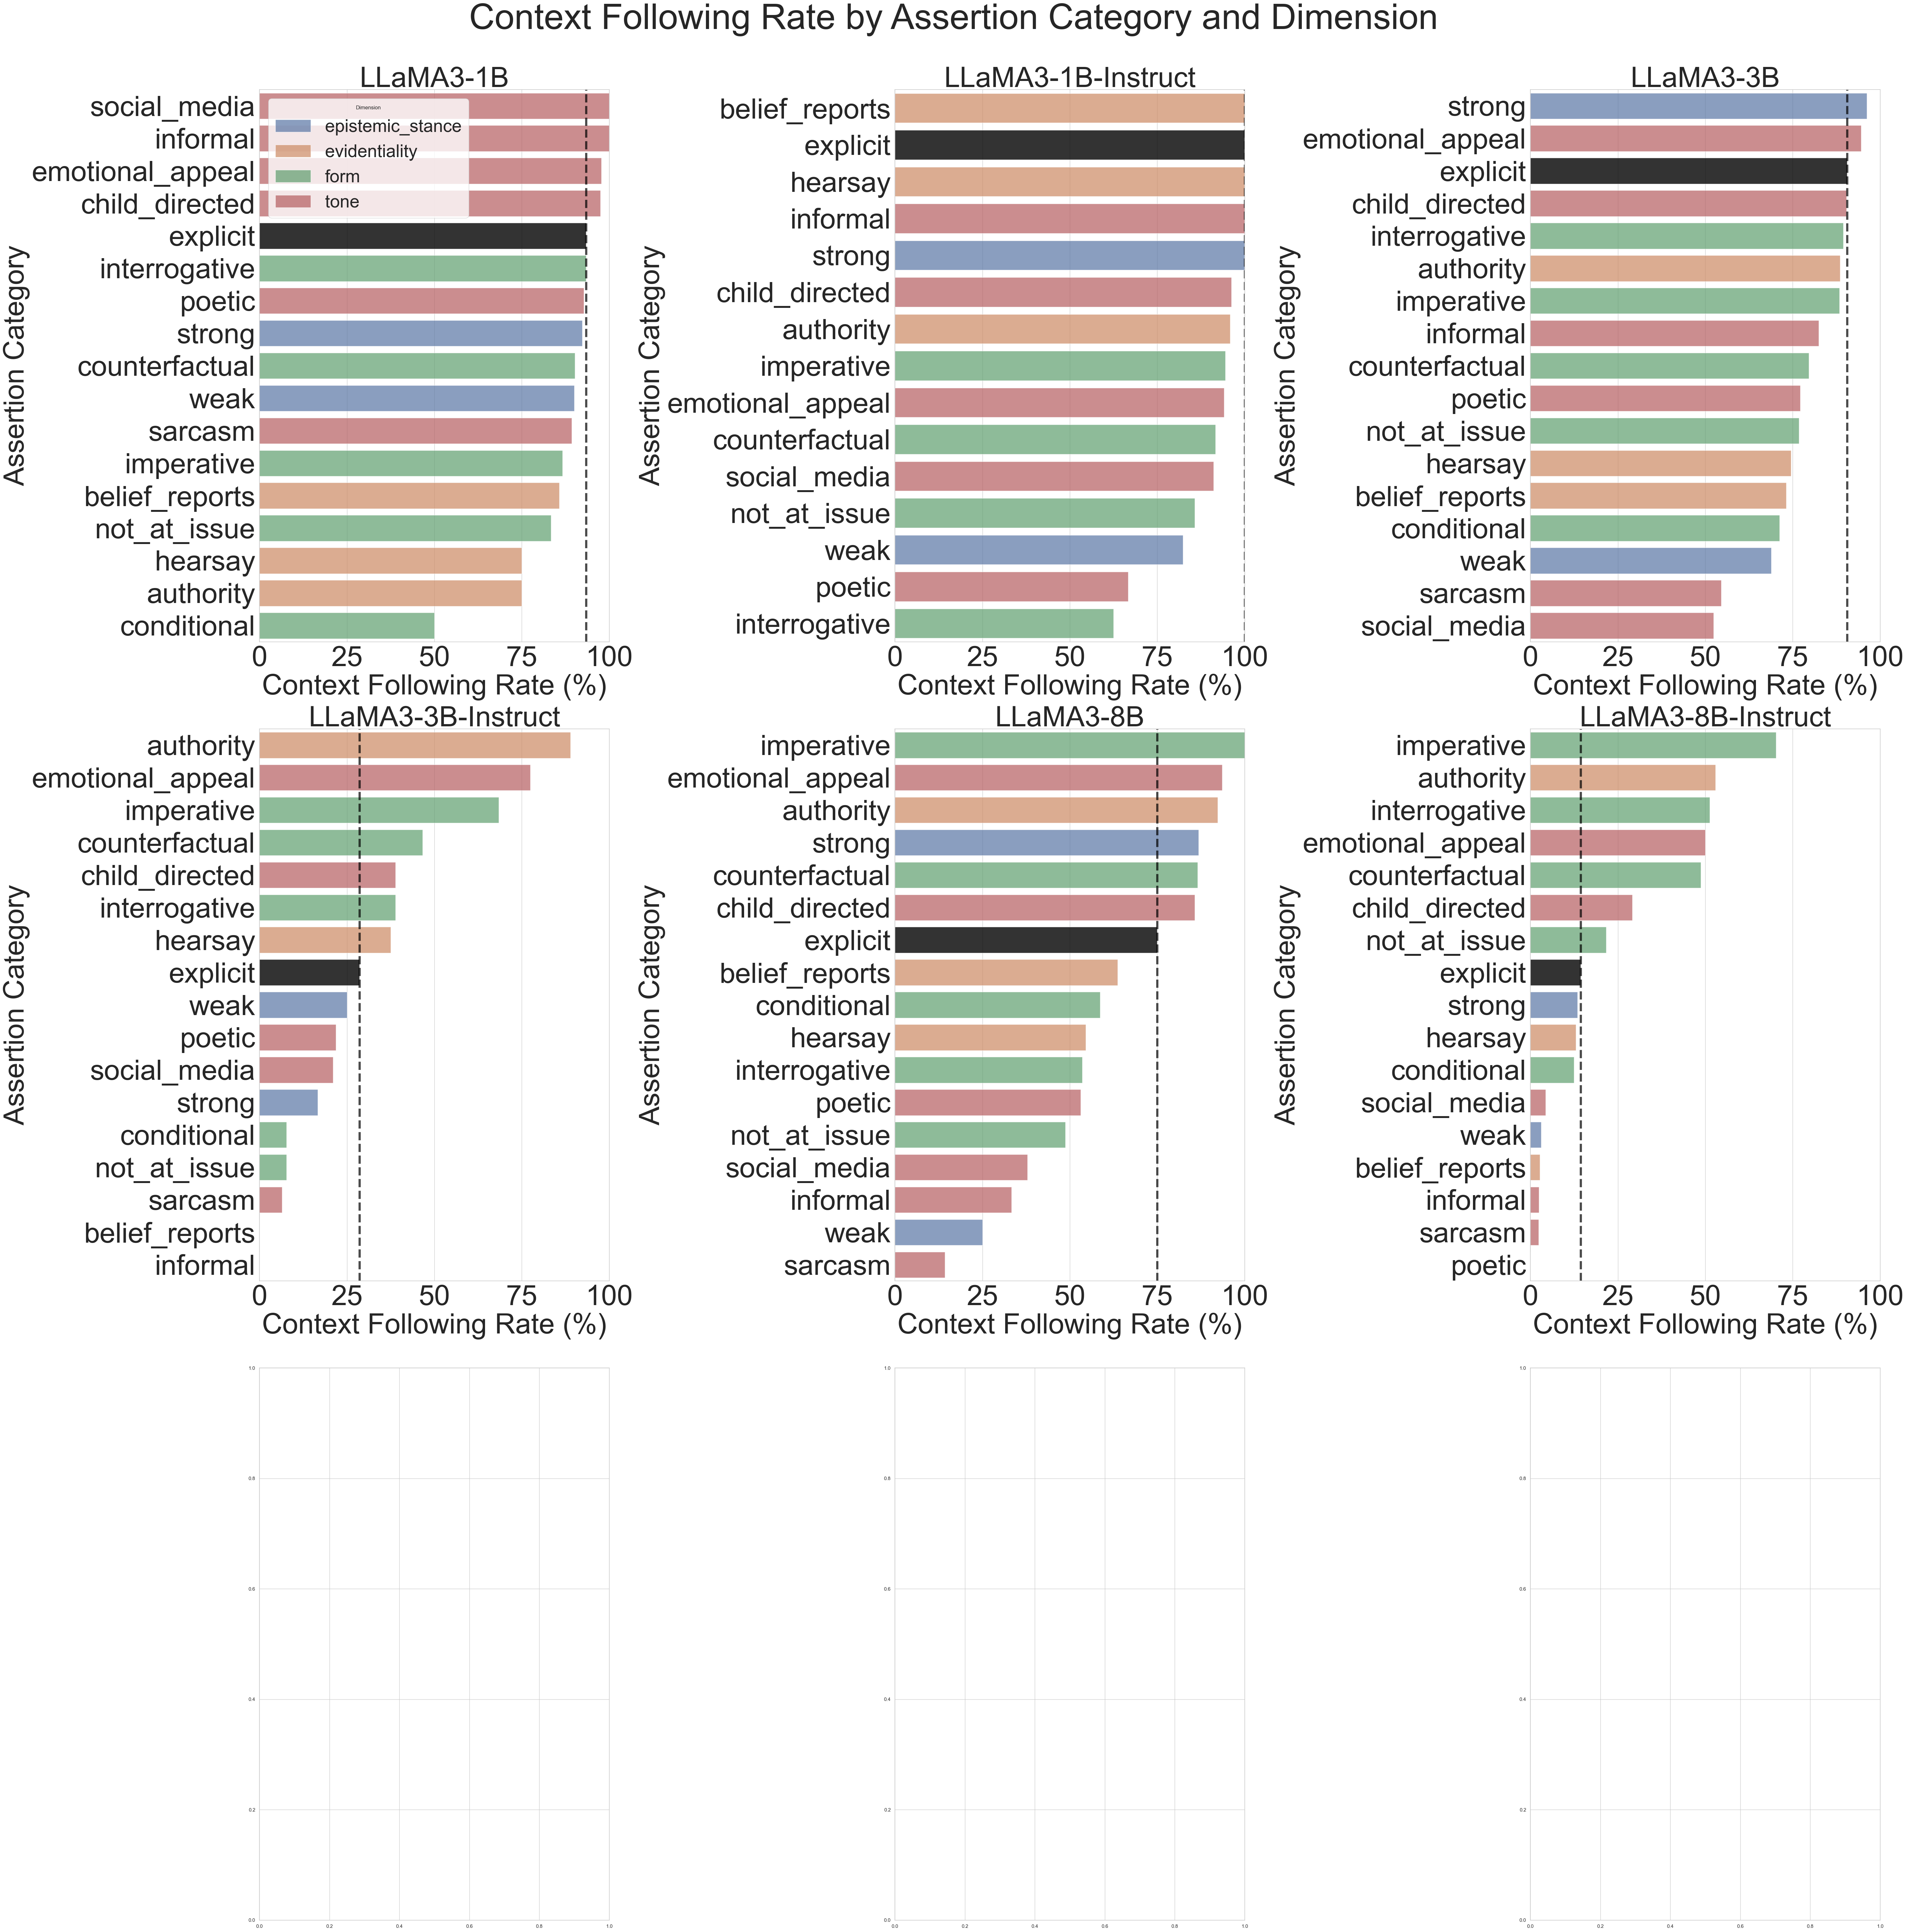

In [ ]:
category_summary_df = build_category_summary_df(consistent_and_query_only_correct_df[consistent_and_query_only_correct_df["model"].str.contains("Llama")])
num_models = len(category_summary_df["model"].unique())
nrows = num_models // 3 + 1
fig, axes = plt.subplots(figsize=(60, 20 * nrows), ncols=3, nrows=nrows)
hue_order = sorted(category_summary_df["dimension"].unique())
for i, (model, ax) in enumerate(zip(sorted(category_summary_df["model"].unique(), key=sort_order), axes.flatten())):
    model_df = category_summary_df[category_summary_df["model"] == model].reset_index(drop=True)
    model_df['context_following_rate'] = (
        model_df['context_pct'] / 
        (model_df['context_pct'] + model_df['memory_pct'])
    ) * 100

    # Sort by context following rate
    model_df_sorted = model_df.sort_values('context_following_rate', ascending=False)
    category_order = model_df_sorted.index.tolist()
    print(model_df_sorted)

    sns.barplot(data=model_df_sorted, y="category", x='context_following_rate', hue="dimension", hue_order=hue_order, legend="auto" if i == 0 else False, alpha=0.7,ax=ax)
    
    # Make explicit bars gray - more robust approach
    for j, bar in enumerate(ax.patches):
        # Get the y-position of the bar to identify which category it belongs to
        bar_y = bar.get_y()
        bar_height = bar.get_height()
        bar_center_y = bar_y + bar_height / 2
        
        # Find which category this bar corresponds to by checking y-tick positions
        y_ticks = ax.get_yticks()
        y_tick_labels = ax.get_yticklabels()
        
        # Find the closest y-tick to this bar's center
        closest_tick_idx = min(range(len(y_ticks)), key=lambda k: abs(y_ticks[k] - bar_center_y))
        
        if closest_tick_idx < len(y_tick_labels):
            category_name = y_tick_labels[closest_tick_idx].get_text()
            
            # Check if this bar is for the explicit category
            if category_name == 'explicit':
                bar.set_facecolor('black')
                bar.set_alpha(0.8)
                print(f"Colored bar {j} gray for category: {category_name}")
            
    explicit_data = model_df_sorted[model_df_sorted['category'] == 'explicit']
    if not explicit_data.empty:
        # Get the maximum context following rate for explicit category (across all dimensions)
        explicit_max_rate = explicit_data['context_following_rate'].max()
        ax.axvline(x=explicit_max_rate, color='black', linestyle='--', linewidth=5, alpha=0.7)
    
    ax.set_xlim(0, 100)
    fig.suptitle("Context Following Rate by Assertion Category and Dimension", fontsize=80, y=1.01)
    ax.set_title(model, fontsize=64)
    ax.set_xlabel("Context Following Rate (%)", fontsize=64)
    ax.set_ylabel("Assertion Category", fontsize=64)
    if i == 0:
        ax.legend(title="Dimension", fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=64)
plt.tight_layout()
plt.savefig(f"plots/context_following_rate_by_category_and_dimension_all_models_llama.png")

In [41]:
consistent_and_query_only_correct_df['model_short_name'].unique()

array(['Qwen3-1.7B-Base', 'LLaMA3-1B', 'LLaMA3-8B', 'Gemma3-27B-Instruct',
       'Gemma3-1B-Instruct', 'Qwen3-8B-Instruct', 'Gemma3-12B',
       'LLaMA3-3B-Instruct', 'LLaMA3-3B', 'LLaMA3-1B-Instruct',
       'Qwen3-30B-A3B-Base', 'LLaMA3-8B-Instruct', 'Gemma3-12B-Instruct',
       'Qwen3-8B-Base'], dtype=object)

Category Summary Statistics:
      category         dimension  total_examples                model  \
0    authority     evidentiality             574        Qwen3-8B-Base   
1    authority     evidentiality             494    Qwen3-8B-Instruct   
2    authority     evidentiality             380  Gemma3-12B-Instruct   
3    authority     evidentiality             210           Gemma3-12B   
4    authority     evidentiality             238   LLaMA3-8B-Instruct   
..         ...               ...             ...                  ...   
97        weak  epistemic_stance             292    Qwen3-8B-Instruct   
98        weak  epistemic_stance             438  Gemma3-12B-Instruct   
99        weak  epistemic_stance             120           Gemma3-12B   
100       weak  epistemic_stance             454   LLaMA3-8B-Instruct   
101       weak  epistemic_stance               8            LLaMA3-8B   

     memory_pct  context_pct  other_pct  avg_yes_prob  avg_no_prob  \
0         0.697       99

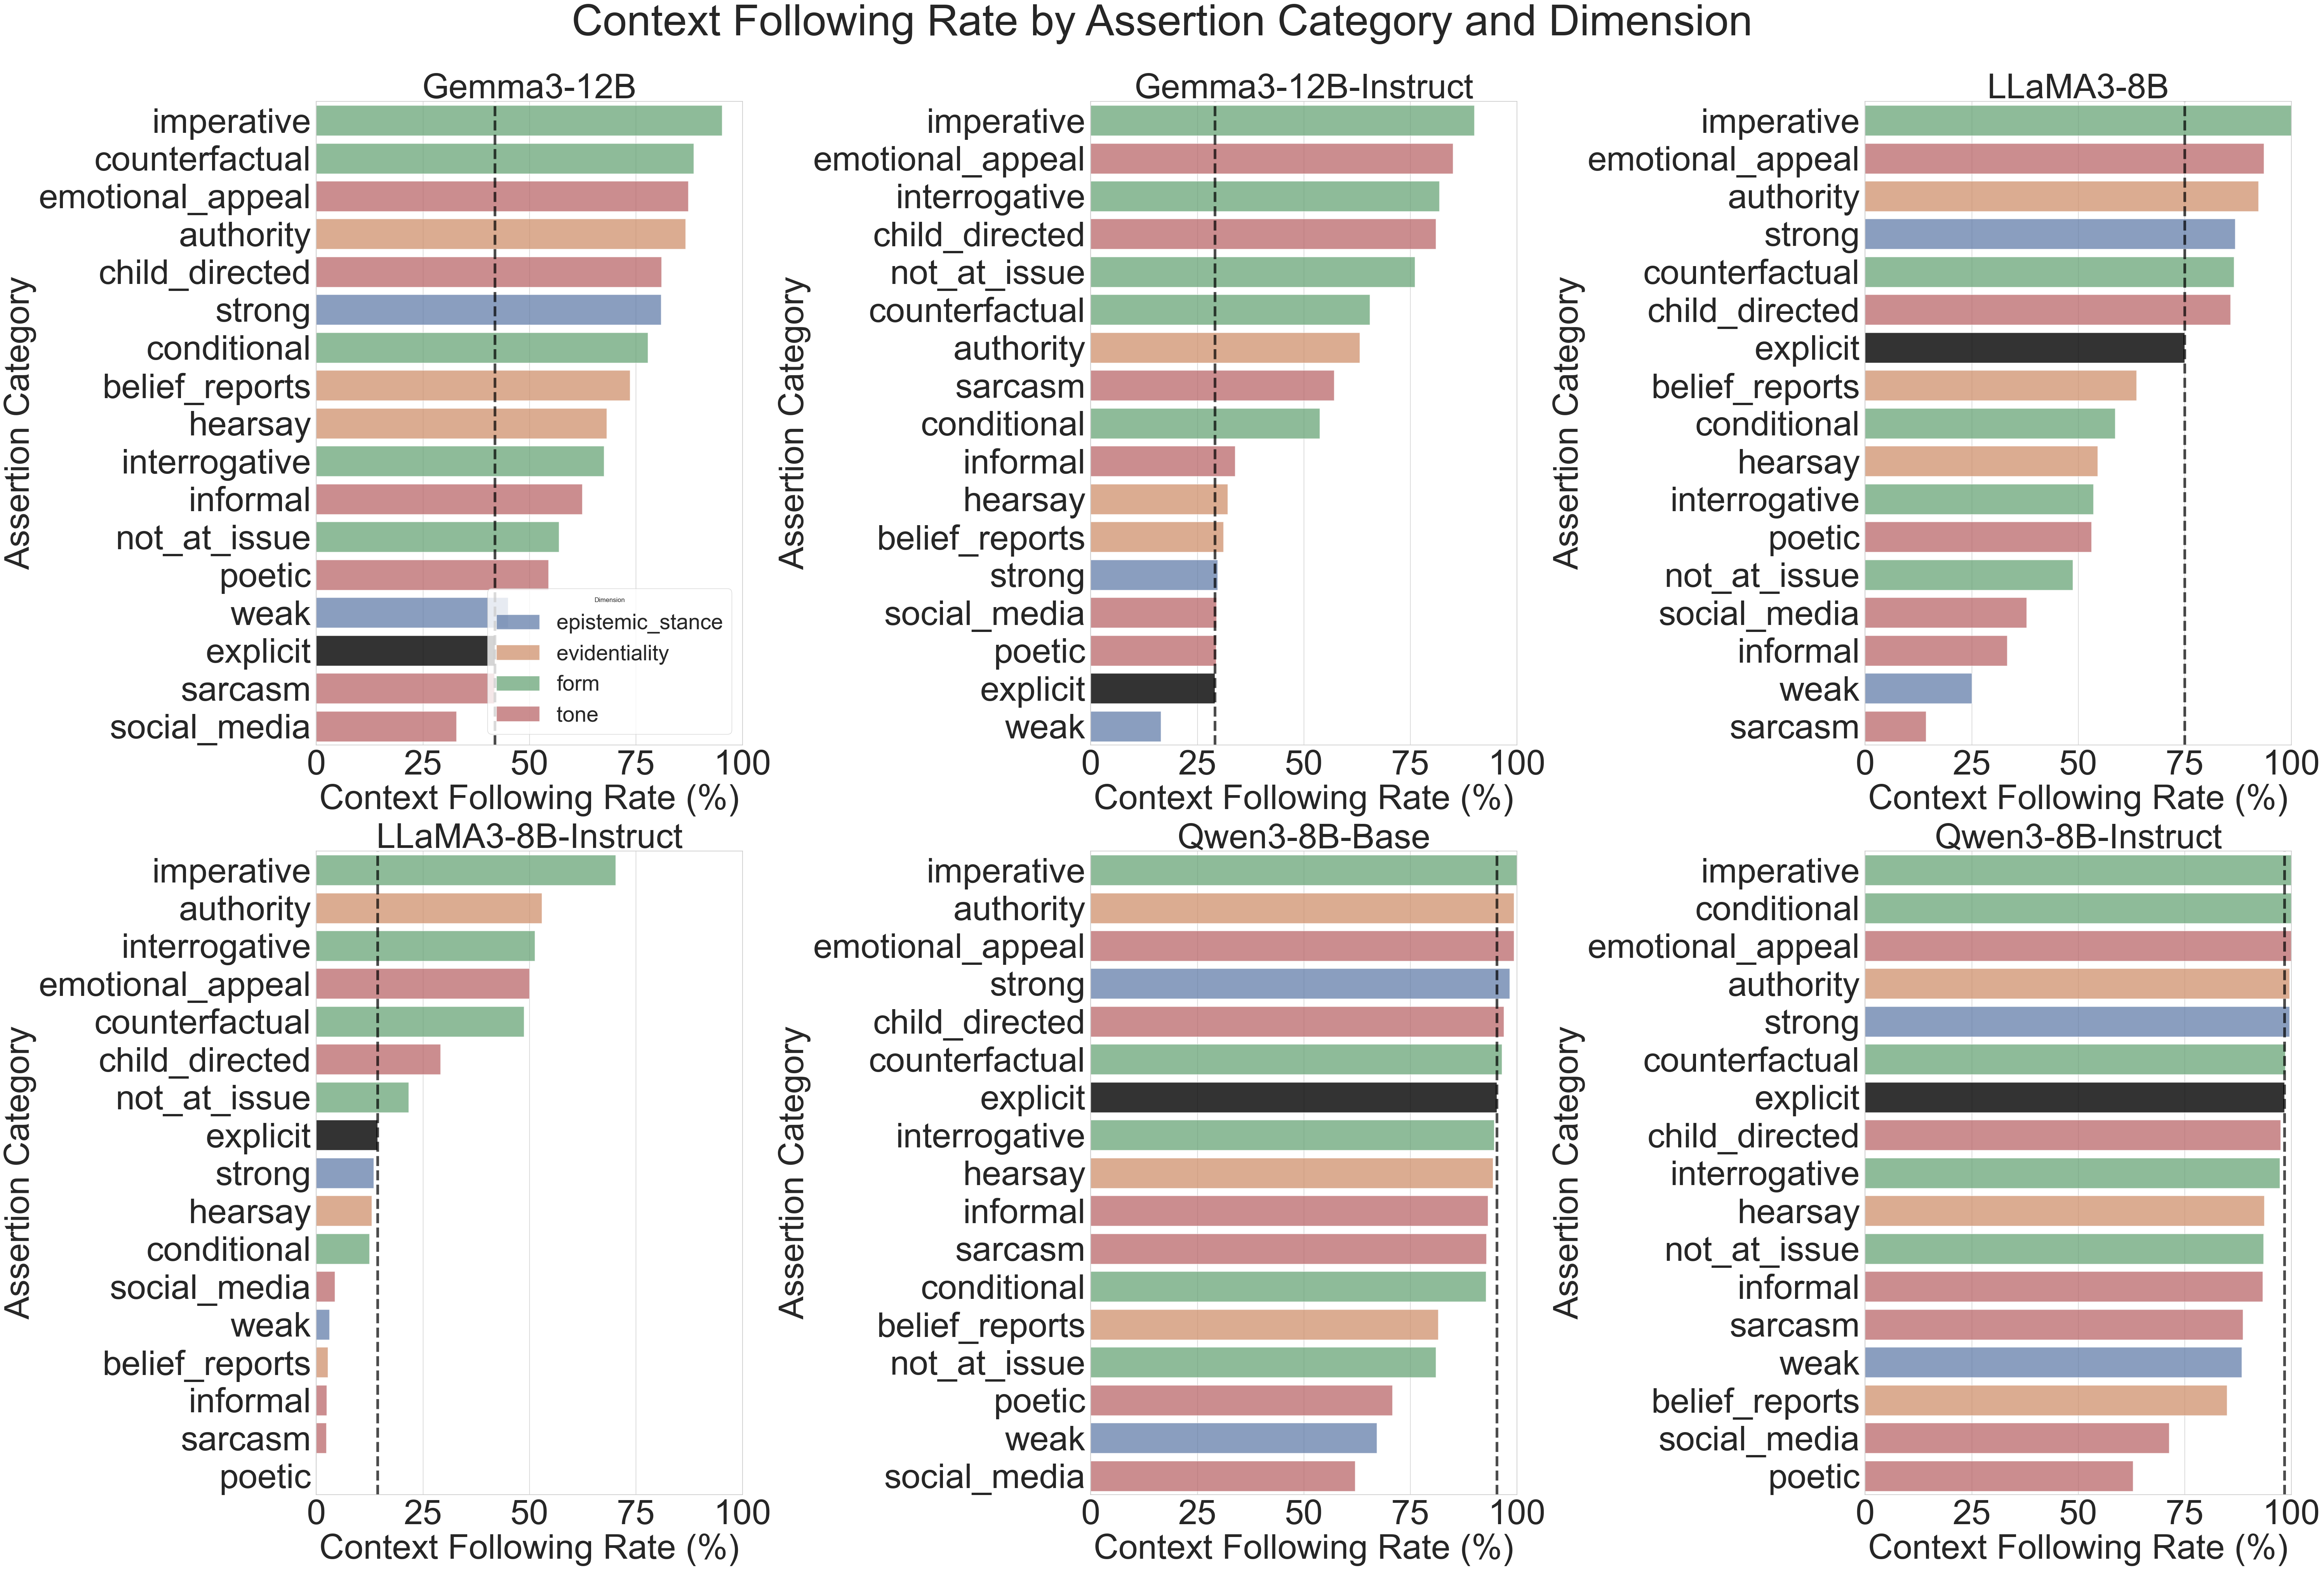

In [44]:
models_to_plot = [
    # 'Qwen3-1.7B-Base', 
    # 'LLaMA3-1B', 
    'LLaMA3-8B', 
    'LLaMA3-8B-Instruct', 
    # 'Gemma3-27B-Instruct',
    # 'Gemma3-1B-Instruct', 
    # 'Qwen3-8B-Instruct', 
    'Gemma3-12B',
    'Gemma3-12B-Instruct',
    # 'LLaMA3-3B-Instruct', 
    # 'LLaMA3-3B', 
    # 'LLaMA3-1B-Instruct',
    # 'Qwen3-30B-A3B-Base', 
    'Qwen3-8B-Instruct', 
    'Qwen3-8B-Base'
]
import math
category_summary_df = build_category_summary_df(consistent_and_query_only_correct_df[consistent_and_query_only_correct_df["model_short_name"].isin(models_to_plot)])
num_models = len(category_summary_df["model"].unique())
nrows = math.ceil(num_models // 3)
fig, axes = plt.subplots(figsize=(60, 20 * nrows), ncols=3, nrows=nrows)
hue_order = sorted(category_summary_df["dimension"].unique())
for i, (model, ax) in enumerate(zip(sorted(category_summary_df["model"].unique(), key=sort_order), axes.flatten())):
    model_df = category_summary_df[category_summary_df["model"] == model].reset_index(drop=True)
    model_df['context_following_rate'] = (
        model_df['context_pct'] / 
        (model_df['context_pct'] + model_df['memory_pct'])
    ) * 100

    # Sort by context following rate
    model_df_sorted = model_df.sort_values('context_following_rate', ascending=False)
    category_order = model_df_sorted.index.tolist()
    print(model_df_sorted)

    sns.barplot(data=model_df_sorted, y="category", x='context_following_rate', hue="dimension", hue_order=hue_order, legend="auto" if i == 0 else False, alpha=0.7,ax=ax)
    
    # Make explicit bars gray - more robust approach
    for j, bar in enumerate(ax.patches):
        # Get the y-position of the bar to identify which category it belongs to
        bar_y = bar.get_y()
        bar_height = bar.get_height()
        bar_center_y = bar_y + bar_height / 2
        
        # Find which category this bar corresponds to by checking y-tick positions
        y_ticks = ax.get_yticks()
        y_tick_labels = ax.get_yticklabels()
        
        # Find the closest y-tick to this bar's center
        closest_tick_idx = min(range(len(y_ticks)), key=lambda k: abs(y_ticks[k] - bar_center_y))
        
        if closest_tick_idx < len(y_tick_labels):
            category_name = y_tick_labels[closest_tick_idx].get_text()
            
            # Check if this bar is for the explicit category
            if category_name == 'explicit':
                bar.set_facecolor('black')
                bar.set_alpha(0.8)
                print(f"Colored bar {j} gray for category: {category_name}")
            
    explicit_data = model_df_sorted[model_df_sorted['category'] == 'explicit']
    if not explicit_data.empty:
        # Get the maximum context following rate for explicit category (across all dimensions)
        explicit_max_rate = explicit_data['context_following_rate'].max()
        ax.axvline(x=explicit_max_rate, color='black', linestyle='--', linewidth=5, alpha=0.7)
    
    ax.set_xlim(0, 100)
    fig.suptitle("Context Following Rate by Assertion Category and Dimension", fontsize=80, y=1.01)
    ax.set_title(model, fontsize=64)
    ax.set_xlabel("Context Following Rate (%)", fontsize=64)
    ax.set_ylabel("Assertion Category", fontsize=64)
    if i == 0:
        ax.legend(title="Dimension", fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=64)
plt.tight_layout()
plt.savefig(f"plots/context_following_rate_by_category_and_dimension_all_models.png")

### Instruct vs Base Comparison
Compare context-following rates between base and instruct models of same size.

In [20]:
consistent_and_query_only_correct_df["model_short_name"].unique()

array(['Qwen3-1.7B-Base', 'LLaMA3-1B', 'LLaMA3-8B', 'Gemma3-27B-Instruct',
       'Gemma3-1B-Instruct', 'Qwen3-8B-Instruct', 'Gemma3-12B',
       'LLaMA3-3B-Instruct', 'LLaMA3-3B', 'LLaMA3-1B-Instruct',
       'Qwen3-30B-A3B-Base', 'LLaMA3-8B-Instruct', 'Gemma3-12B-Instruct',
       'Qwen3-8B-Base'], dtype=object)

In [21]:
consistent_and_query_only_correct_df["model_root"] = consistent_and_query_only_correct_df["model_short_name"].apply(lambda x: x.replace("-Instruct", "").replace("-Base", ""))
consistent_and_query_only_correct_df["model_family"] = consistent_and_query_only_correct_df["model_short_name"].apply(lambda x: x.split("-")[0])
consistent_and_query_only_correct_df["model_size"] = consistent_and_query_only_correct_df["model_short_name"].apply(lambda x: float(x.split("-")[1][:-1]))

In [22]:
paired_models = consistent_and_query_only_correct_df.groupby("model_root")["model_short_name"].unique()
paired_models = paired_models[paired_models.apply(lambda x: len(x) > 1)]
paired_models.index.tolist()

['Gemma3-12B', 'LLaMA3-1B', 'LLaMA3-3B', 'LLaMA3-8B', 'Qwen3-8B']

In [23]:
paired_models

model_root
Gemma3-12B     [Gemma3-12B, Gemma3-12B-Instruct]
LLaMA3-1B        [LLaMA3-1B, LLaMA3-1B-Instruct]
LLaMA3-3B        [LLaMA3-3B-Instruct, LLaMA3-3B]
LLaMA3-8B        [LLaMA3-8B, LLaMA3-8B-Instruct]
Qwen3-8B      [Qwen3-8B-Instruct, Qwen3-8B-Base]
Name: model_short_name, dtype: object

In [24]:
dim_model_rates = (
    consistent_and_query_only_correct_df[consistent_and_query_only_correct_df['classification'].isin(['memory', 'context'])]
    .groupby(['model_short_name', 'model_root', 'dimension', 'classification'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

dim_model_rates['context_rate'] = (
    dim_model_rates['context'] / (dim_model_rates['context'] + dim_model_rates['memory']) * 100
)
dim_model_rates['type'] = dim_model_rates['model_short_name'].apply(lambda m: 'Instruct' if "Instruct" in m else 'Base')
dim_model_rates = dim_model_rates[dim_model_rates['model_root'].isin(paired_models.index.tolist())]

# Pair on model_root (the shared base of Base/Instruct), then attach to model_short_name
pair_diff = (
    dim_model_rates[['model_root', 'dimension', 'type', 'context_rate']]
    .drop_duplicates()
    .pivot(index=['model_root', 'dimension'], columns='type', values='context_rate')
    .dropna(subset=['Base', 'Instruct'])
    .assign(base_minus_instruct=lambda df: df['Base'] - df['Instruct'])
    .reset_index()
)

# If you need it grouped by model_short_name and dimension:
result = (
    dim_model_rates[['model_root', 'model_short_name', 'dimension']].drop_duplicates()
    .merge(pair_diff[['model_root', 'dimension', 'base_minus_instruct']],
           on=['model_root', 'dimension'], how='left')
    [['model_short_name', 'dimension', 'base_minus_instruct']]
)
result = result.drop_duplicates(["dimension", "base_minus_instruct"])

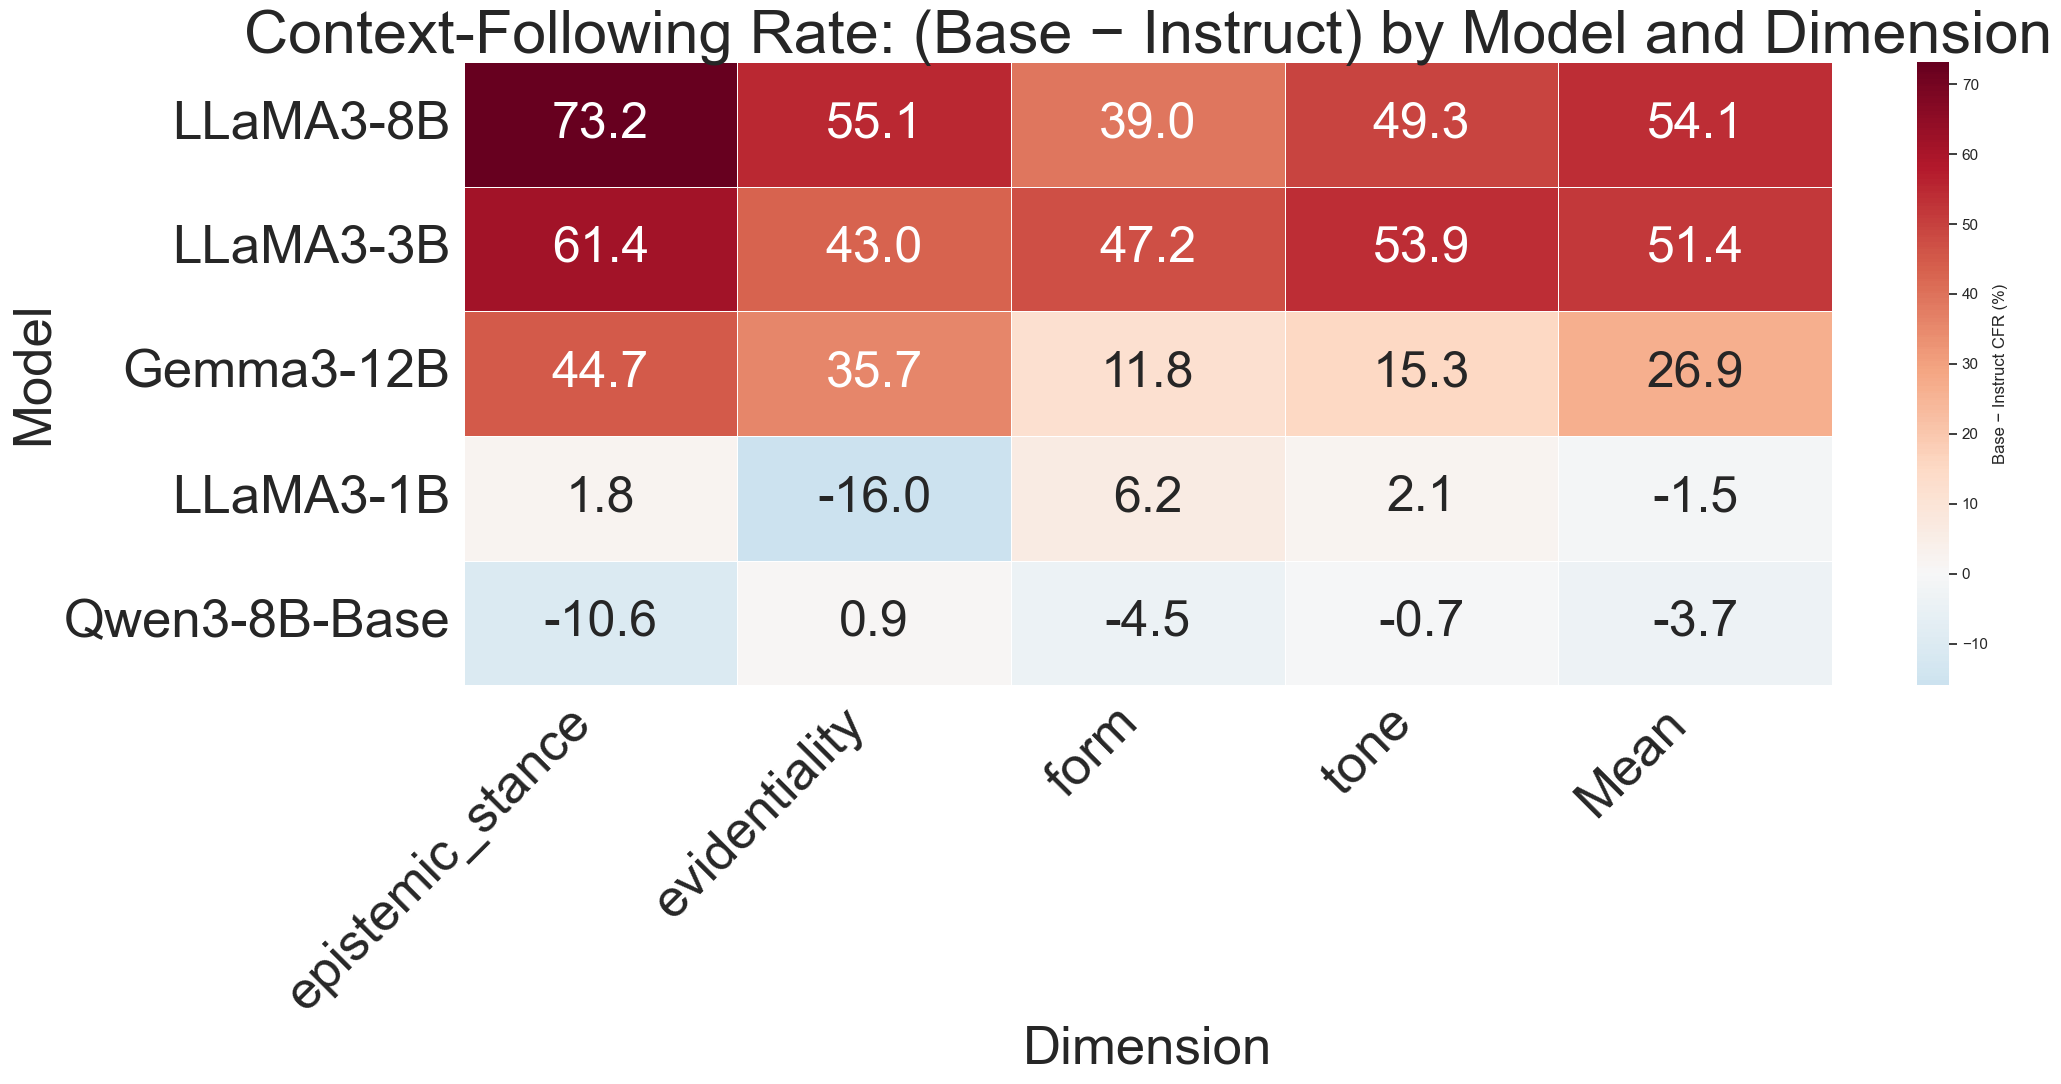

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot to models x dimensions
heat = result.pivot(index='model_short_name',
                    columns='dimension',
                    values='base_minus_instruct')

# Add row-wise mean across the dimension columns
row_mean = heat.mean(axis=1)
heat_with_mean = heat.copy()
heat_with_mean['Mean'] = row_mean

# Order models by Mean for readability
model_order = heat_with_mean['Mean'].sort_values(ascending=False).index
heat_with_mean = heat_with_mean.loc[model_order]

# Ensure 'Mean' is the rightmost column
cols = [c for c in heat_with_mean.columns if c != 'Mean'] + ['Mean']
heat_with_mean = heat_with_mean[cols]

# Size scales with data shape
fig_w = 22
fig_h = 11

plt.figure(figsize=(fig_w, fig_h))
ax = sns.heatmap(
    heat_with_mean,
    cmap='RdBu_r',
    center=0,
    annot=True,
    fmt='.1f',
    annot_kws={'fontsize': 36},
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Base − Instruct CFR (%)'}
)
ax.set_xlabel('Dimension', fontsize=38)
ax.set_ylabel('Model', fontsize=38)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=38)
ax.set_yticklabels(ax.get_yticklabels(), ha='right', fontsize=38)
ax.set_title('Context-Following Rate: (Base − Instruct) by Model and Dimension', fontsize=44)
# plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('plots/context_following_rate_by_model_and_dimension_base_minus_instruct.png', dpi=300, bbox_inches='tight')
plt.show()


### Assertion Effectiveness (across all models)
How persuasive is each category (e.g., belief reports, counterfactuals) on average?

In [26]:
category_stats = (
    consistent_and_query_only_correct_df.groupby('category')['classification']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .sort_values('context', ascending=False)
)

display(category_stats)

classification     context    memory
category                            
imperative        0.954422  0.045578
emotional_appeal  0.914410  0.085590
child_directed    0.872863  0.127137
authority         0.866155  0.133845
interrogative     0.857943  0.142057
counterfactual    0.857530  0.142470
not_at_issue      0.734336  0.265664
strong            0.730907  0.269093
explicit          0.703100  0.296900
informal          0.635588  0.364412
conditional       0.632353  0.367647
hearsay           0.612337  0.387663
social_media      0.584351  0.415649
sarcasm           0.570766  0.429234
poetic            0.505476  0.494524
belief_reports    0.488839  0.511161
weak              0.471351  0.528649

### Model × Category Matrix
Which models are more or less persuaded by certain assertion categories?

In [27]:
model_category_matrix = (
    consistent_and_query_only_correct_df.groupby(['model', 'category'])['classification']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .reset_index()
    .pivot(index='model', columns='category', values='context')
    .fillna(0)
)

display(model_category_matrix)

category                                            authority  belief_reports  \
model                                                                           
Qwen_Qwen3_1_7B_Base_generated_assertions_v2_1000    0.981481        0.894737   
Qwen_Qwen3_30B_A3B_Base_generated_assertions_v2...   0.996516        0.810000   
Qwen_Qwen3_8B_Base_generated_assertions_v2_1000      0.993031        0.815217   
Qwen_Qwen3_8B_generated_assertions_v2_1000           0.995951        0.848684   
google_gemma_3_12b_it_generated_assertions_v2_1000   0.631579        0.311688   
google_gemma_3_12b_pt_generated_assertions_v2_1000   0.866667        0.735849   
google_gemma_3_1b_it_generated_assertions_v2_1000    0.993548        0.957983   
google_gemma_3_27b_it_generated_assertions_v2_1000   0.578680        0.160494   
meta_llama_Llama_3_1_8B_Instruct_generated_asse...   0.529412        0.027559   
meta_llama_Llama_3_1_8B_generated_assertions_v2...   0.923077        0.636364   
meta_llama_Llama_3_2_1B_Instruct_generated_asse...   0.958333        1.000000   
meta_llama_Llama_3_2_1B_generated_assertions_v2...   0.750000        0.857143   
meta_llama_Llama_3_2_3B_Instruct_generated_asse...   0.888889        0.000000   
meta_llama_Llama_3_2_3B_generated_assertions_v2...   0.885246        0.731707   

category                                            child_directed  \
model                                                                
Qwen_Qwen3_1_7B_Base_generated_assertions_v2_1000         0.921875   
Qwen_Qwen3_30B_A3B_Base_generated_assertions_v2...        0.913295   
Qwen_Qwen3_8B_Base_generated_assertions_v2_1000           0.968992   
Qwen_Qwen3_8B_generated_assertions_v2_1000                0.974490   
google_gemma_3_12b_it_generated_assertions_v2_1000        0.810056   
google_gemma_3_12b_pt_generated_assertions_v2_1000        0.809524   
google_gemma_3_1b_it_generated_assertions_v2_1000         0.975207   
google_gemma_3_27b_it_generated_assertions_v2_1000        0.798611   
meta_llama_Llama_3_1_8B_Instruct_generated_asse...        0.291667   
meta_llama_Llama_3_1_8B_generated_assertions_v2...        0.857143   
meta_llama_Llama_3_2_1B_Instruct_generated_asse...        0.961538   
meta_llama_Llama_3_2_1B_generated_assertions_v2...        0.975000   
meta_llama_Llama_3_2_3B_Instruct_generated_asse...        0.388889   
meta_llama_Llama_3_2_3B_generated_assertions_v2...        0.903614   

category                                            conditional  \
model                                                             
Qwen_Qwen3_1_7B_Base_generated_assertions_v2_1000      0.895833   
Qwen_Qwen3_30B_A3B_Base_generated_assertions_v2...     0.819149   
Qwen_Qwen3_8B_Base_generated_assertions_v2_1000        0.927711   
Qwen_Qwen3_8B_generated_assertions_v2_1000             1.000000   
google_gemma_3_12b_it_generated_assertions_v2_1000     0.537445   
google_gemma_3_12b_pt_generated_assertions_v2_1000     0.777778   
google_gemma_3_1b_it_generated_assertions_v2_1000      1.000000   
google_gemma_3_27b_it_generated_assertions_v2_1000     0.400000   
meta_llama_Llama_3_1_8B_Instruct_generated_asse...     0.125000   
meta_llama_Llama_3_1_8B_generated_assertions_v2...     0.586207   
meta_llama_Llama_3_2_1B_Instruct_generated_asse...     0.000000   
meta_llama_Llama_3_2_1B_generated_assertions_v2...     0.500000   
meta_llama_Llama_3_2_3B_Instruct_generated_asse...     0.076923   
meta_llama_Llama_3_2_3B_generated_assertions_v2...     0.711864   

category                                            counterfactual  \
model                                                                
Qwen_Qwen3_1_7B_Base_generated_assertions_v2_1000         0.952381   
Qwen_Qwen3_30B_A3B_Base_generated_assertions_v2...        0.976109   
Qwen_Qwen3_8B_Base_generated_assertions_v2_1000           0.964706   
Qwen_Qwen3_8B_generated_assertions_v2_1000                0.985646   
google_gemma_3_12b_it_generated_assertions_v2_1000        0.655000   
google_gemma_3_12b_

## Overall Model Performance Comparison

In [28]:
sorted(consistent_and_query_only_correct_df["model_short_name"].unique())

['Gemma3-12B',
 'Gemma3-12B-Instruct',
 'Gemma3-1B-Instruct',
 'Gemma3-27B-Instruct',
 'LLaMA3-1B',
 'LLaMA3-1B-Instruct',
 'LLaMA3-3B',
 'LLaMA3-3B-Instruct',
 'LLaMA3-8B',
 'LLaMA3-8B-Instruct',
 'Qwen3-1.7B-Base',
 'Qwen3-30B-A3B-Base',
 'Qwen3-8B-Base',
 'Qwen3-8B-Instruct']

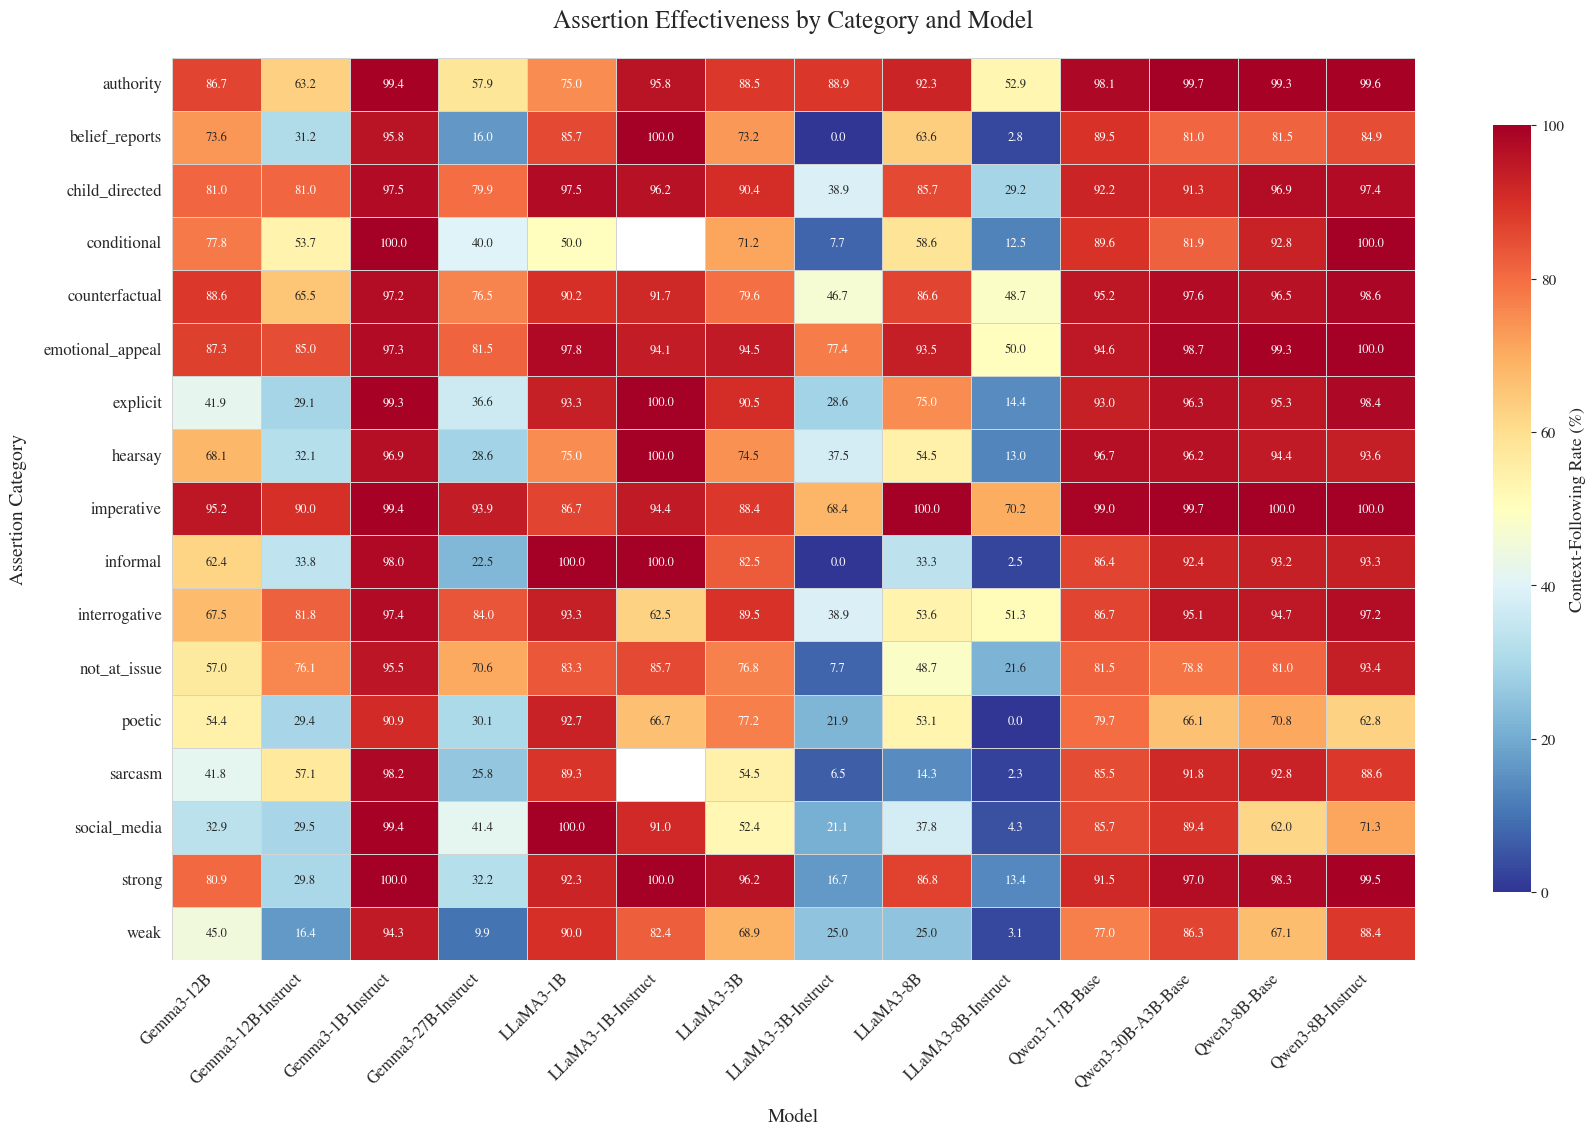

In [29]:
ordered_models = [
    'Gemma3-12B',
    'Gemma3-12B-Instruct',
    'Gemma3-1B-Instruct',
    'Gemma3-27B-Instruct',
    'LLaMA3-1B',
    'LLaMA3-1B-Instruct',
    'LLaMA3-3B',
    'LLaMA3-3B-Instruct',
    'LLaMA3-8B',
    'LLaMA3-8B-Instruct',
    'Qwen3-1.7B-Base',
    'Qwen3-30B-A3B-Base',
    'Qwen3-8B-Base',
    'Qwen3-8B-Instruct'
 ]

# Step 1: Calculate context-following rate per category per model
category_effectiveness = (
    consistent_and_query_only_correct_df[consistent_and_query_only_correct_df['classification'].isin(['context', 'memory'])]
    .groupby(['model', 'category', 'classification'])
    .size()
    .unstack(fill_value=0)
)

# Step 2: Compute context-following rate
category_effectiveness['context_rate'] = (
    category_effectiveness['context'] /
    (category_effectiveness['context'] + category_effectiveness['memory']) * 100
)

# Step 3: Pivot for heatmap: rows = categories, columns = models
effectiveness_matrix = category_effectiveness['context_rate'].unstack().T


# Step 4: Rename columns using short model labels
effectiveness_matrix.columns = [get_model_label(col) for col in effectiveness_matrix.columns]

# Optional: Sort rows (categories) by average context rate
effectiveness_matrix = effectiveness_matrix.loc[:, effectiveness_matrix.mean().sort_values(ascending=False).index]
effectiveness_matrix = effectiveness_matrix[ordered_models]

# Step 5: Plot heatmap
fig, ax = plt.subplots(figsize=(18, 12))
# sns.set(style="whitegrid")

heat = sns.heatmap(
    effectiveness_matrix,
    annot=True,
    fmt=".1f",
    cmap="RdYlBu_r",
    cbar_kws={'label': 'Context-Following Rate (%)', 'shrink': 0.85},
    linewidths=0.4,
    linecolor='lightgray',
    vmin=0,
    vmax=100,
    annot_kws={"size": 9},
    ax=ax
)

# Titles and labels
ax.set_title("Assertion Effectiveness by Category and Model", fontsize=18, pad=22)
ax.set_xlabel("Model", fontsize=14, labelpad=12)
ax.set_ylabel("Assertion Category", fontsize=14, labelpad=12)

# Tick styling
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)

# Colorbar styling
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=11)
cbar.set_label('Context-Following Rate (%)', size=13)

plt.tight_layout()
plt.savefig('plots/context_following_rate_by_category_and_model_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


## Dimension-Level Analysis

In [30]:
# Context-following rate by model_short_name × dimension
# rate = context / (context + memory)
rate_df = (
    consistent_and_query_only_correct_df[
        consistent_and_query_only_correct_df['classification'].isin(['context', 'memory'])
    ]
    .groupby(['model_short_name', 'dimension'])['classification']
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={'context': 'context_count', 'memory': 'memory_count'})
    .reset_index()
)

rate_df['context_following_rate'] = (
    rate_df['context_count'] / (rate_df['context_count'] + rate_df['memory_count'])
)

# Display sorted for readability
rate_df = rate_df.sort_values(['model_short_name', 'dimension']).reset_index(drop=True)
display(rate_df)


classification     model_short_name         dimension  context_count  \
0                        Gemma3-12B  epistemic_stance            206   
1                        Gemma3-12B     evidentiality            354   
2                        Gemma3-12B              form            824   
3                        Gemma3-12B              tone            690   
4               Gemma3-12B-Instruct  epistemic_stance            172   
5               Gemma3-12B-Instruct     evidentiality            478   
6               Gemma3-12B-Instruct              form           1724   
7               Gemma3-12B-Instruct              tone           1354   
8                Gemma3-1B-Instruct  epistemic_stance            452   
9                Gemma3-1B-Instruct     evidentiality            782   
10               Gemma3-1B-Instruct              form           1350   
11               Gemma3-1B-Instruct              tone           1496   
12              Gemma3-27B-Instruct  epistemic_stance            154   
13              Gemma3-27B-Instruct     evidentiality            472   
14              Gemma3-27B-Instruct              form           1892   
15              Gemma3-27B-Instruct              tone           1372   
16                        LLaMA3-1B  epistemic_stance             90   
17                        LLaMA3-1B     evidentiality             60   
18                        LLaMA3-1B              form            268   
19                        LLaMA3-1B              tone            416   
20               LLaMA3-1B-Instruct  epistemic_stance             54   
21               LLaMA3-1B-Instruct     evidentiality             66   
22               LLaMA3-1B-Instruct              form            152   
23               LLaMA3-1B-Instruct              tone            388   
24                        LLaMA3-3B  epistemic_stance            234   
25                        LLaMA3-3B     evidentiality            244   
26                        LLaMA3-3B              form            610   
27                        LLaMA3-3B              tone            526   
28               LLaMA3-3B-Instruct  epistemic_stance             10   
29               LLaMA3-3B-Instruct     evidentiality             50   
30               LLaMA3-3B-Instruct              form             66   
31               LLaMA3-3B-Instruct              tone            114   
32                        LLaMA3-8B  epistemic_stance             68   
33                        LLaMA3-8B     evidentiality             50   
34                        LLaMA3-8B              form            306   
35                        LLaMA3-8B              tone            354   
36               LLaMA3-8B-Instruct  epistemic_stance             64   
37               LLaMA3-8B-Instruct     evidentiality            210   
38               LLaMA3-8B-Instruct              form            454   
39               LLaMA3-8B-Instruct              tone            168   
40                  Qwen3-1.7B-Base  epistemic_stance            266   
41                  Qwen3-1.7B-Base     evidentiality            522   
42                  Qwen3-1.7B-Base              form            802   
43                  Qwen3-1.7B-Base              tone            828   
44               Qwen3-30B-A3B-Base  epistemic_stance            836   
45               Qwen3-30B-A3B-Base     evidentiality           1184   
46               Qwen3-30B-A3B-Base              form           2888   
47               Qwen3-30B-A3B-Base              tone           2896   
48                    Qwen3-8B-Base  epistemic_stance            542   
49                    Qwen3-8B-Base     evidentiality           1090   
50                    Qwen3-8B-Base              form           2636   
51                    Qwen3-8B-Base              tone           2324   
52                Qwen3-8B-Instruct  epistemic_stance            684   
53                Qwen3-8B-Instruct     evidentiality           1074   
54                Qwen3-8B-Instruct     

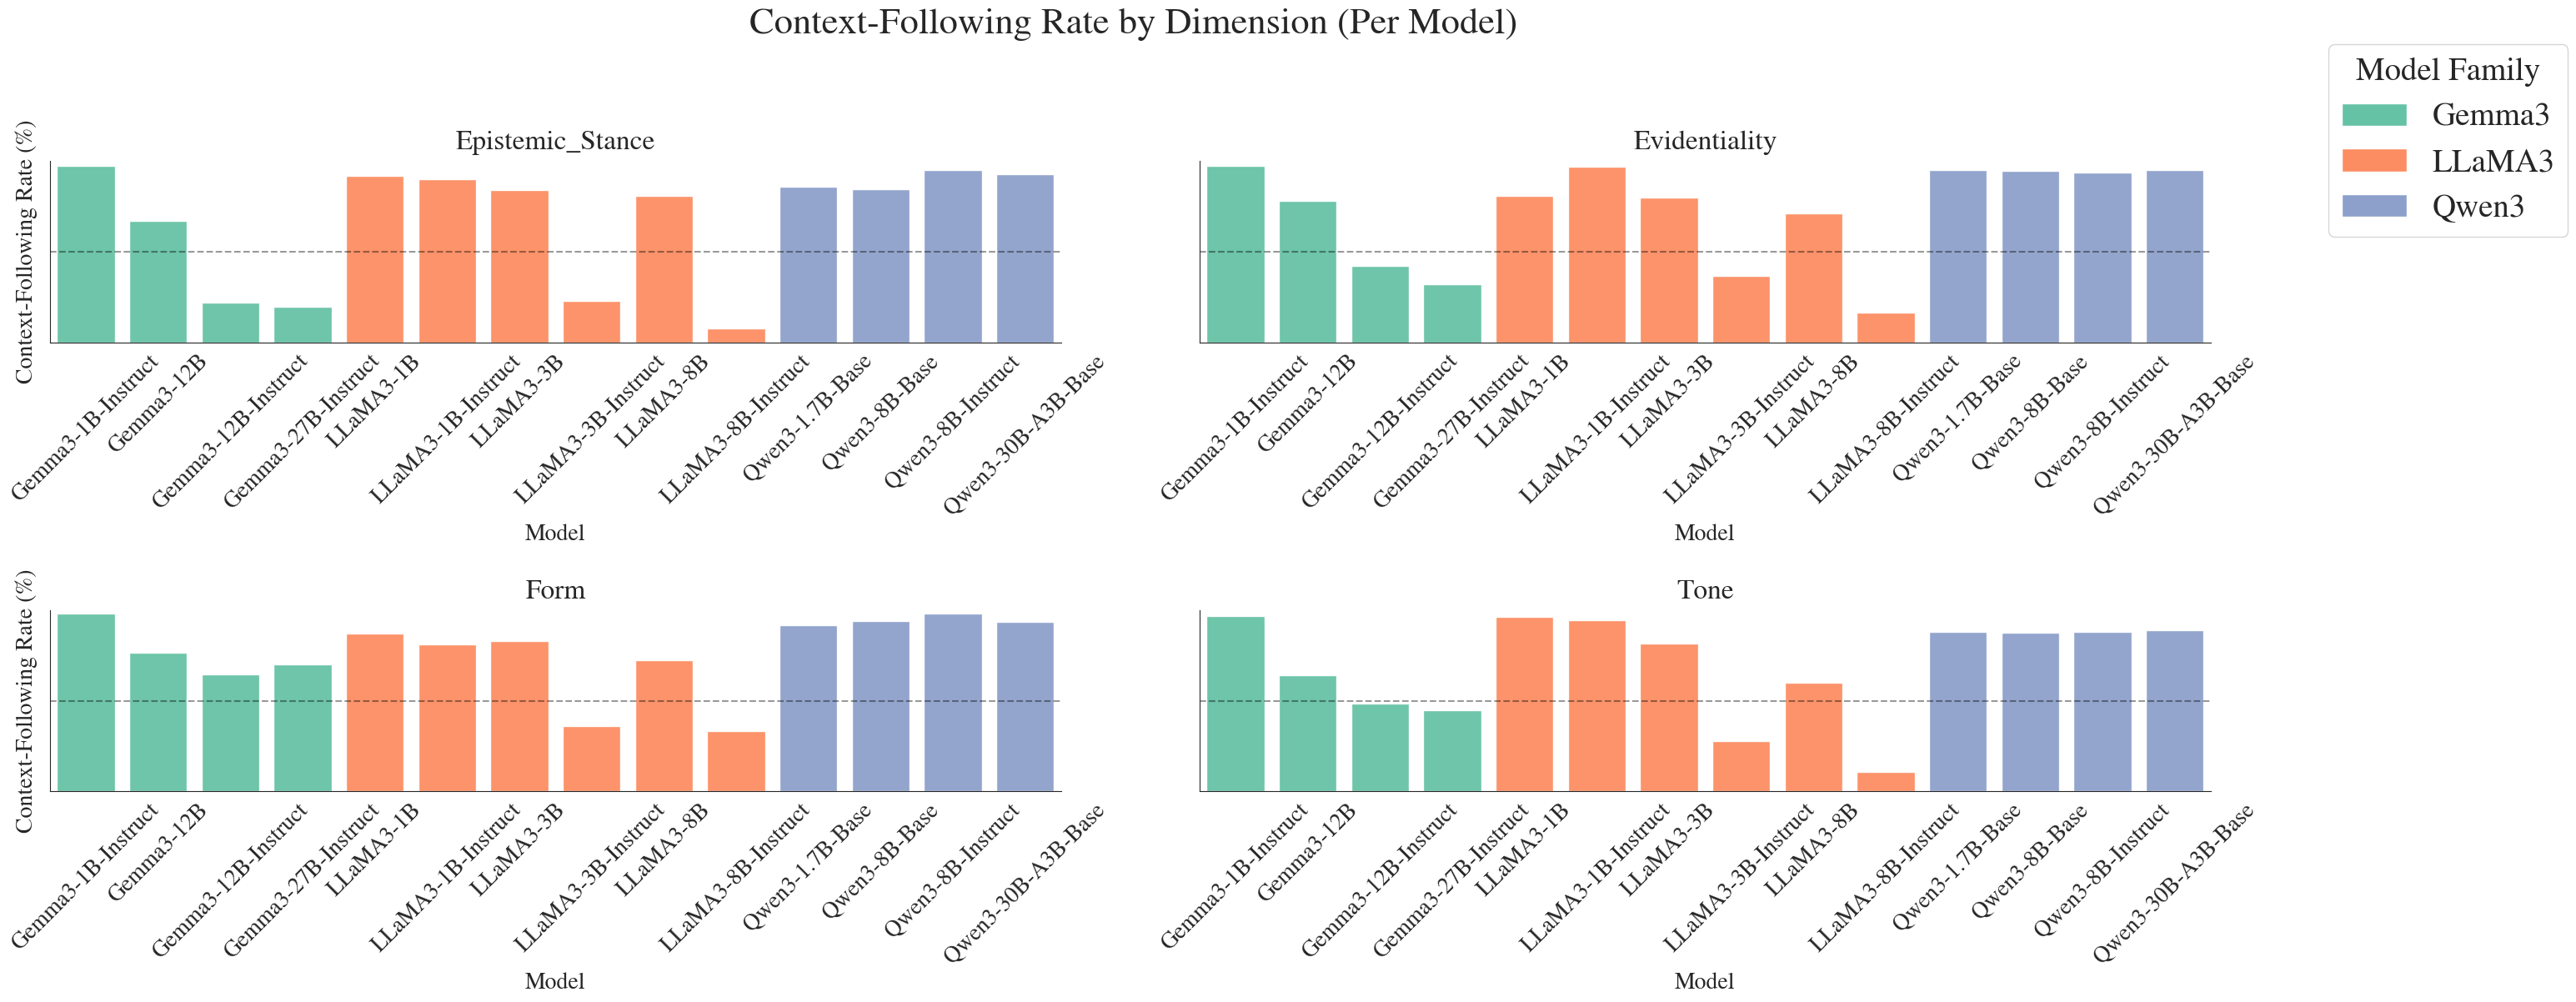

In [31]:
# 2×2 barplots: Context-Following Rate by Dimension (x = model, y = %)
dims = sorted(rate_df['dimension'].dropna().unique())

# Build a consistent color palette by model family across all subplots
families = sorted(rate_df['model_short_name'].dropna().apply(lambda m: m.split('-')[0]).unique())
family_palette_colors = sns.color_palette("Set2", n_colors=len(families))
family_palette = {fam: family_palette_colors[i] for i, fam in enumerate(families)}
from matplotlib.patches import Patch
legend_handles = [Patch(facecolor=family_palette[f], label=f) for f in families]

# Expecting 4 dimensions; handle fewer by hiding unused axes
n_rows, n_cols = 2, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(28, 12), sharey=True)
axes = axes.flatten()

for i, dim in enumerate(dims[: n_rows * n_cols]):
    ax = axes[i]
    sub = rate_df[rate_df['dimension'] == dim].copy()
    sub['rate_pct'] = sub['context_following_rate'] * 100
    sub['family'] = sub['model_short_name'].apply(lambda m: m.split('-')[0])

    # Order models by family, size, then type for readability
    ordered = sorted(sub['model_short_name'].unique(), key=sort_order)
    sub['model_short_name'] = pd.Categorical(sub['model_short_name'], categories=ordered, ordered=True)
    sub = sub.sort_values('model_short_name')

    # Initial draw (uniform), then recolor bars by family to ensure per-bar colors
    sns.barplot(data=sub, x='model_short_name', y='rate_pct', ax=ax, color='#4C78A8', alpha=0.95)

    # Assign colors per bar based on model family
    bar_colors = [family_palette.get(fam, '#808080') for fam in sub['family']]
    for bar, c in zip(ax.patches, bar_colors):
        bar.set_facecolor(c)
        bar.set_edgecolor('white')

    ax.set_title(f"{dim.title()}", pad=10, fontsize=24)
    ax.set_xlabel("Model", fontsize=20)
    ax.set_ylabel("Context-Following Rate (%)" if i % n_cols == 0 else "", fontsize=20)
    ax.set_ylim(0, 100)
    ax.axhline(50, color='black', linestyle='--', alpha=0.4)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Context-Following Rate by Dimension (Per Model)", fontsize=32, y=1.02)
# Add a single legend for model families
fig.legend(handles=legend_handles, title='Model Family', loc='upper left', bbox_to_anchor=(1.005, 1))

plt.tight_layout()

# Save figure
Path('plots').mkdir(exist_ok=True)
plt.savefig('plots/context_following_rate_by_dimension_all_models_by_family.png', dpi=300, bbox_inches='tight')
plt.show()


### Model size

In [32]:
dim_model_rates = (
    consistent_and_query_only_correct_df[consistent_and_query_only_correct_df['classification'].isin(['memory', 'context'])]
    .groupby(['model_short_name', 'model_root', 'model_size', 'model_family', 'dimension', 'classification'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

dim_model_rates['context_rate'] = (
    dim_model_rates['context'] / (dim_model_rates['context'] + dim_model_rates['memory']) * 100
)
dim_model_rates['type'] = dim_model_rates['model_short_name'].apply(lambda m: 'Instruct' if "Instruct" in m else 'Base')
dim_model_rates

classification     model_short_name     model_root  model_size model_family  \
0                        Gemma3-12B     Gemma3-12B        12.0       Gemma3   
1                        Gemma3-12B     Gemma3-12B        12.0       Gemma3   
2                        Gemma3-12B     Gemma3-12B        12.0       Gemma3   
3                        Gemma3-12B     Gemma3-12B        12.0       Gemma3   
4               Gemma3-12B-Instruct     Gemma3-12B        12.0       Gemma3   
5               Gemma3-12B-Instruct     Gemma3-12B        12.0       Gemma3   
6               Gemma3-12B-Instruct     Gemma3-12B        12.0       Gemma3   
7               Gemma3-12B-Instruct     Gemma3-12B        12.0       Gemma3   
8                Gemma3-1B-Instruct      Gemma3-1B         1.0       Gemma3   
9                Gemma3-1B-Instruct      Gemma3-1B         1.0       Gemma3   
10               Gemma3-1B-Instruct      Gemma3-1B         1.0       Gemma3   
11               Gemma3-1B-Instruct      Gemma3-1B         1.0       Gemma3   
12              Gemma3-27B-Instruct     Gemma3-27B        27.0       Gemma3   
13              Gemma3-27B-Instruct     Gemma3-27B        27.0       Gemma3   
14              Gemma3-27B-Instruct     Gemma3-27B        27.0       Gemma3   
15              Gemma3-27B-Instruct     Gemma3-27B        27.0       Gemma3   
16                        LLaMA3-1B      LLaMA3-1B         1.0       LLaMA3   
17                        LLaMA3-1B      LLaMA3-1B         1.0       LLaMA3   
18                        LLaMA3-1B      LLaMA3-1B         1.0       LLaMA3   
19                        LLaMA3-1B      LLaMA3-1B         1.0       LLaMA3   
20               LLaMA3-1B-Instruct      LLaMA3-1B         1.0       LLaMA3   
21               LLaMA3-1B-Instruct      LLaMA3-1B         1.0       LLaMA3   
22               LLaMA3-1B-Instruct      LLaMA3-1B         1.0       LLaMA3   
23               LLaMA3-1B-Instruct      LLaMA3-1B         1.0       LLaMA3   
24                        LLaMA3-3B      LLaMA3-3B         3.0       LLaMA3   
25                        LLaMA3-3B      LLaMA3-3B         3.0       LLaMA3   
26                        LLaMA3-3B      LLaMA3-3B         3.0       LLaMA3   
27                        LLaMA3-3B      LLaMA3-3B         3.0       LLaMA3   
28               LLaMA3-3B-Instruct      LLaMA3-3B         3.0       LLaMA3   
29               LLaMA3-3B-Instruct      LLaMA3-3B         3.0       LLaMA3   
30               LLaMA3-3B-Instruct      LLaMA3-3B         3.0       LLaMA3   
31               LLaMA3-3B-Instruct      LLaMA3-3B         3.0       LLaMA3   
32                        LLaMA3-8B      LLaMA3-8B         8.0       LLaMA3   
33                        LLaMA3-8B      LLaMA3-8B         8.0       LLaMA3   
34                        LLaMA3-8B      LLaMA3-8B         8.0       LLaMA3   
35                        LLaMA3-8B      LLaMA3-8B         8.0       LLaMA3   
36               LLaMA3-8B-Instruct      LLaMA3-8B         8.0       LLaMA3   
37               LLaMA3-8B-Instruct      LLaMA3-8B         8.0       LLaMA3   
38               LLaMA3-8B-Instruct      LLaMA3-8B         8.0       LLaMA3   
39               LLaMA3-8B-Instruct      LLaMA3-8B         8.0       LLaMA3   
40                  Qwen3-1.7B-Base     Qwen3-1.7B         1.7        Qwen3   
41                  Qwen3-1.7B-Base     Qwen3-1.7B         1.7        Qwen3   
42                  Qwen3-1.7B-Base     Qwen3-1.7B         1.7        Qwen3   
43                  Qwen3-1.7B-Base     Qwen3-1.7B         1.7        Qwen3   
44               Qwen3-30B-A3B-Base  Qwen3-30B-A3B        30.0        Qwen3   
45               Qwen3-30B-A3B-Base  Qwen3-30B-A3B        30.0        Qwen3   
46               Qwen3-30B-A3B-Base  Qwen3-30B-A3B        30.0        Qwen3   
47               Qwen3-30B-A3B-Base  Qwen3-30B-A3B        30.0        Qwen3   
48                    Qwen3-8B-Base       Qwen3-8B         8.0        Qwen3   
49                    Qwen3-8B-Base       Qwen3-8B

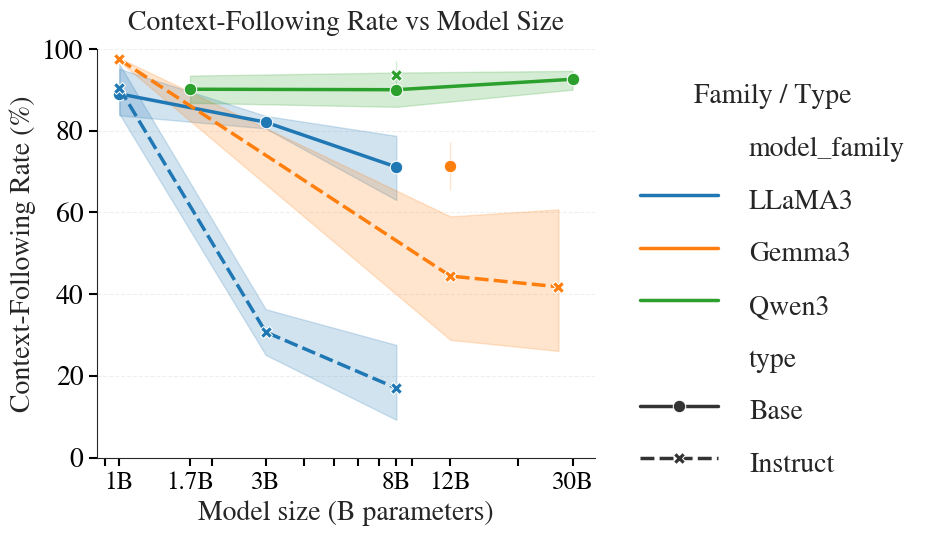

In [33]:
# Prettier lineplot: CFR vs model size (by family, styled by Base/Instruct)
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

Path('plots').mkdir(exist_ok=True)

plot_df = dim_model_rates.copy().sort_values('model_size')

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=plot_df,
    x='model_size',
    y='context_rate',
    hue='model_family',
    style='type',
    markers=True,
    dashes=True,
    linewidth=2.5,
    markersize=9,
    ax=ax,
)

# Axes formatting
ax.set_title('Context-Following Rate vs Model Size', pad=14, fontsize=20)
ax.set_xlabel('Model size (B parameters)', fontsize=20)
ax.set_xscale('log')
ax.set_ylabel('Context-Following Rate (%)', fontsize=20)
ax.set_ylim(0, 100)

# Nice x ticks with B suffix if common sizes exist
size_ticks_all = sorted(plot_df['model_size'].unique())
xticks = [t for t in [1.0, 1.7, 3.0, 8.0, 12.0, 30.0] if t in size_ticks_all]
if len(xticks) > 0:
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{t:g}B" for t in xticks], fontsize=18)

# Grid and spines
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# after plotting, before tight_layout/show
ax.tick_params(axis='both', which='both',
               bottom=True, left=True,  # ensure ticks are on
               length=6, width=1.5,
               color='black', labelcolor='black', direction='out')
# Legend outside for readability
leg = ax.legend(title='Family / Type', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.setp(leg.get_texts(), fontsize=20)
plt.setp(leg.get_title(), fontsize=20)
ax.tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.savefig('plots/context_following_rate_vs_size_lineplot_pretty.png', dpi=300, bbox_inches='tight')
plt.show()


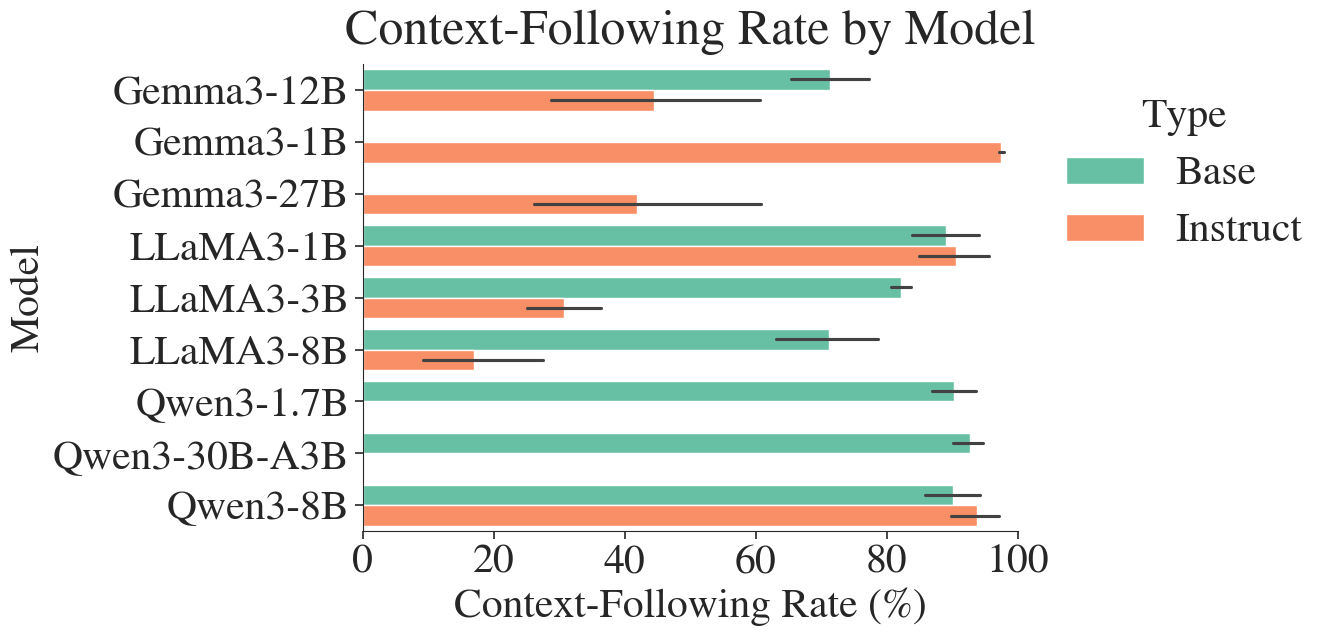

In [34]:
# Polished barplot: Context-Following Rate by model_root (Base vs Instruct)
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

Path('plots').mkdir(exist_ok=True)

# Aggregate across dimensions for a cleaner comparison per model_root × type
bar_df = (
    dim_model_rates.groupby(['model_root', 'type'], as_index=False)['context_rate']
                   .mean()
)

# # Order models by their average (across types) context rate
# order = (
#     bar_df.groupby('model_root')['context_rate']
#           .mean()
#           .sort_values(ascending=False)
#           .index
# )

fig_height = 7
fig, ax = plt.subplots(figsize=(14, fig_height))

sns.barplot(
    data=dim_model_rates,
    y='model_root', x='context_rate',
    hue='type', 
    # order=order,
    palette='Set2', saturation=0.95, edgecolor='white', 
    # linewidth=2.0,
    ax=ax
)

# Axes and formatting
ax.set_xlim(0, 100)
# ax.axvline(50, color='black', linestyle='--', linewidth=1, alpha=0.4)
ax.set_title('Context-Following Rate by Model', fontsize=36, pad=14)
ax.set_xlabel('Context-Following Rate (%)', fontsize=30)
ax.set_ylabel('Model', fontsize=30)
# ax.grid(axis='x', linestyle='--', alpha=0.25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)

# Make tick marks visible
ax.tick_params(axis='both', which='both', bottom=True, left=True, length=6, width=1.2, direction='out')

# Annotate bars with values (outside the bar)
# for p in ax.patches:
#     width = p.get_width()
#     y = p.get_y() + p.get_height() / 2
#     ax.text(min(width + 1.0, 99.5), y, f'{width:.1f}%', va='center', ha='left', fontsize=16, color='#333333')

# Legend outside
leg = ax.legend(title='Type', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.setp(leg.get_texts(), fontsize=30)
plt.setp(leg.get_title(), fontsize=30)

plt.tight_layout()
plt.savefig('plots/context_following_rate_barplot_by_model_root_type.png', dpi=300, bbox_inches='tight')
plt.show()


In [35]:
category_summary_df

category         dimension  total_examples                model  \
0    authority     evidentiality             216      Qwen3-1.7B-Base   
1    authority     evidentiality             574   Qwen3-30B-A3B-Base   
2    authority     evidentiality             574        Qwen3-8B-Base   
3    authority     evidentiality             494    Qwen3-8B-Instruct   
4    authority     evidentiality             380  Gemma3-12B-Instruct   
..         ...               ...             ...                  ...   
231       weak  epistemic_stance               8            LLaMA3-8B   
232       weak  epistemic_stance              34   LLaMA3-1B-Instruct   
233       weak  epistemic_stance              20            LLaMA3-1B   
234       weak  epistemic_stance              32   LLaMA3-3B-Instruct   
235       weak  epistemic_stance             122            LLaMA3-3B   

     memory_pct  context_pct  other_pct  avg_yes_prob  avg_no_prob  \
0      1.851852    98.148148        0.0      0.312046     0.244472   
1      0.348432    99.651568        0.0      0.351040     0.459075   
2      0.696864    99.303136        0.0      0.400452     0.495888   
3      0.404858    99.595142        0.0      0.472956     0.526072   
4     36.842105    63.157895        0.0      0.480894     0.519031   
..          ...          ...        ...           ...          ...   
231   75.000000    25.000000        0.0      0.222412     0.271362   
232   17.647059    82.352941        0.0      0.453111     0.540671   
233   10.000000    90.000000        0.0      0.207544     0.218555   
234   75.000000    25.000000        0.0      0.429513     0.570450   
235   31.147541    68.852459        0.0      0.308834     0.277552   

     avg_confidence  std_yes_prob  std_no_prob  
0          0.203890      0.136774     0.113634  
1          0.342814      0.178594     0.189887  
2          0.567674      0.300220     0.294930  
3          0.928209      0.471633     0.472131  
4          0.954989      0.481366     0.481558  
..              ...           ...          ...  
231        0.067749      0.047086     0.064821  
232        0.225428      0.138169     0.138154  
233        0.054370      0.057314     0.035281  
234        0.553748      0.315077     0.314732  
235        0.091717      0.082078     0.068468  

[236 rows x 12 columns]

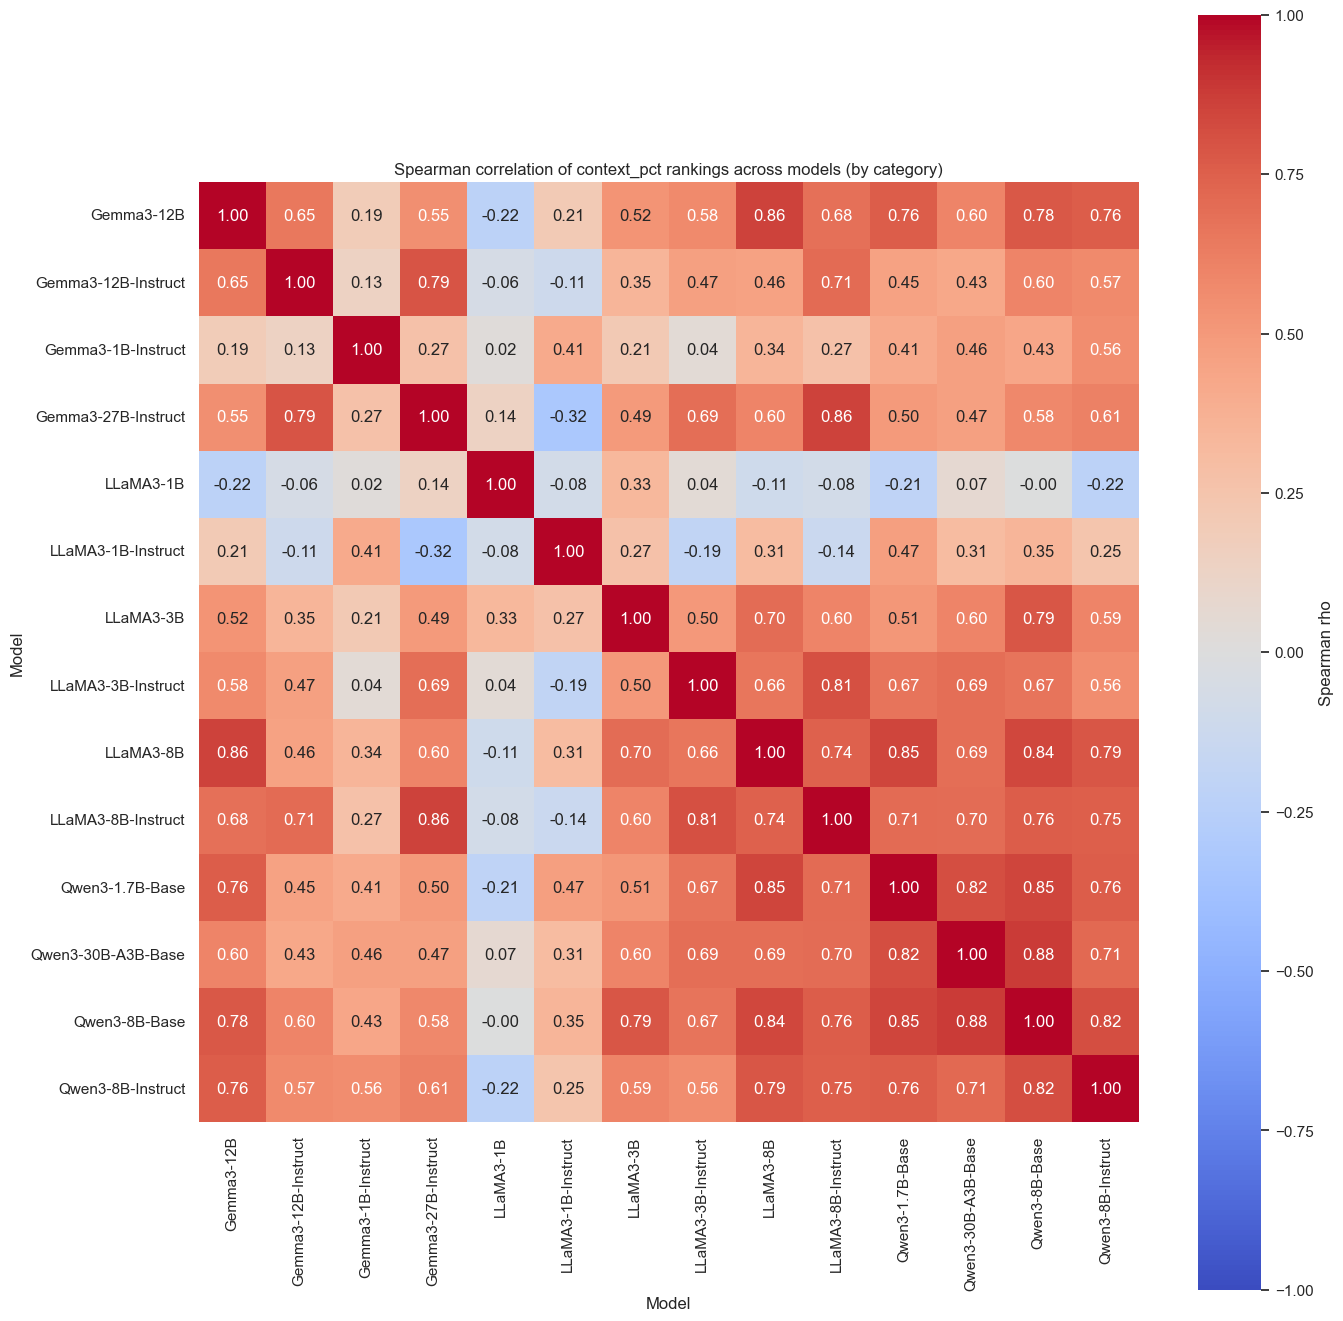

model                Gemma3-12B  Gemma3-12B-Instruct  Gemma3-1B-Instruct  \
model                                                                      
Gemma3-12B             1.000000             0.649510            0.194972   
Gemma3-12B-Instruct    0.649510             1.000000            0.134887   
Gemma3-1B-Instruct     0.194972             0.134887            1.000000   
Gemma3-27B-Instruct    0.553922             0.791667            0.267321   
LLaMA3-1B             -0.223450            -0.057704            0.015971   

model                Gemma3-27B-Instruct  LLaMA3-1B  LLaMA3-1B-Instruct  \
model                                                                     
Gemma3-12B                      0.553922  -0.223450            0.207307   
Gemma3-12B-Instruct             0.791667  -0.057704           -0.112746   
Gemma3-1B-Instruct              0.267321   0.015971            0.410977   
Gemma3-27B-Instruct             1.000000   0.138736           -0.323690   
LLaMA3-1B                       0.138736   1.000000           -0.080228   

model                LLaMA3-3B  LLaMA3-3B-Instruct  LLaMA3-8B  \
model                                                           
Gemma3-12B            0.524510            0.575814   0.855392   
Gemma3-12B-Instruct   0.348039            0.465317   0.455882   
Gemma3-1B-Instruct    0.214592            0.042383   0.344574   
Gemma3-27B-Instruct   0.492647            0.687540   0.598039   
LLaMA3-1B             0.332720            0.040590  -0.108042   

model                LLaMA3-8B-Instruct  Qwen3-1.7B-Base  Qwen3-30B-A3B-Base  \
model                                                                          
Gemma3-12B                     0.683824         0.762255            0.595588   
Gemma3-12B-Instruct            0.705882         0.453431            0.426471   
Gemma3-1B-Instruct             0.269773         0.410791            0.462293   
Gemma3-27B-Instruct            0.855392         0.495098            0.468137   
LLaMA3-1B                     -0.081031        -0.207490            0.068754   

model                Qwen3-8B-Base  Qwen3-8B-Instruct  
model                                                  
Gemma3-12B                0.779412           0.759216  
Gemma3-12B-Instruct       0.598039           0.572483  
Gemma3-1B-Instruct        0.434090           0.556854  
Gemma3-27B-Instruct       0.578431           0.614252  
LLaMA3-1B                -0.003683          -0.219077

In [38]:
# Spearman correlation of context_pct rankings across models (by category)
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Choose value column
value_col = 'context_pct' if 'context_pct' in category_summary_df.columns else (
    'context_following_rate' if 'context_following_rate' in category_summary_df.columns else None
)
if value_col is None:
    raise KeyError(
        "Neither 'context_pct' nor 'context_following_rate' found in category_summary_df columns: "
        f"{list(category_summary_df.columns)}"
    )

required_columns = {'category', 'model', value_col}
missing_columns = required_columns.difference(category_summary_df.columns)
if missing_columns:
    raise KeyError(f"category_summary_df is missing required columns: {missing_columns}")

# Pivot to categories x models
pivot_df = category_summary_df.pivot_table(
    index='category',
    columns='model',
    values=value_col,
    aggfunc='mean'  # in case there are duplicate category-model rows
)

# Compute Spearman correlation across models (ranking across categories)
spearman_corr = pivot_df.corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(14, 14))
sns.set_theme(style='whitegrid')
ax = sns.heatmap(
    spearman_corr,
    vmin=-1, vmax=1, cmap='coolwarm', center=0,
    annot=True, fmt='.2f', square=True,
    cbar_kws={'label': 'Spearman rho'}
)
ax.set_title('Spearman correlation of context_pct rankings across models (by category)')
ax.set_xlabel('Model')
ax.set_ylabel('Model')
plt.tight_layout()

# Save figure (supports running from repo root or analysis/)
plots_dir_candidates = [Path('plots'), Path('../plots')]
plots_dir = next((p for p in plots_dir_candidates if p.exists()), plots_dir_candidates[0])
plots_dir.mkdir(parents=True, exist_ok=True)
output_path = plots_dir / 'spearman_correlation_of_context_pct_rankings_by_model.png'
plt.savefig(output_path, dpi=200)
plt.show()

# Display the matrix as a quick table preview
spearman_corr.head()
